In [1]:
from lib.dataset_utils import *
import pickle
import numpy as np
import nltk
import string
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from lib.scores import *
from lib.plot_utils import *
from lib.models import bootstrap_test, Bert, Roberta
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
MODELS = ["Bayes", "DecisionTree", "RandomForest", "Bert", "Roberta", "SocBert", "Llama3 Zero Shot", "Llama3 Three Shot"]
DATASETS = ["GoEmotions", "TwitterData", "GoEmotionsGrouped"]
BASE_MODELS_DIR = "./checkpoints/"

GOEMOTIONS_MODELS_PATH = {
    "Bayes": f"{BASE_MODELS_DIR}GoEmotions/nb_classifier.pkl",
    "DecisionTree": f"{BASE_MODELS_DIR}GoEmotions/dt_classifier.pkl",
    "RandomForest": f"{BASE_MODELS_DIR}GoEmotions/rf_classifier.pkl",
    "Bert": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_Bert.pth",
    "Roberta": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_Roberta.pth",
    "SocBert": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_Socbert.pth",
}

GOEMOTIONS_GROUPED_MODELS_PATH = {
    "Bayes": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_grouped_bayes.pkl",
    "DecisionTree": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_grouped_dt.pkl",
    "RandomForest": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_grouped_rt.pkl",
    "Bert": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_Bert_Ekman.pth",
    "Roberta": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_Grouped_Roberta.pth",
    "SocBert": f"{BASE_MODELS_DIR}GoEmotions/GoEmotions_Socbert_Ekman.pth",
}

TWITTER_MODELS_PATH = {
    "Bayes": f"{BASE_MODELS_DIR}TwitterData/nb_classifier.pkl",
    "DecisionTree": f"{BASE_MODELS_DIR}TwitterData/dt_classifier.pkl",
    "RandomForest": f"{BASE_MODELS_DIR}TwitterData/rf_classifier.pkl",
    "Bert": f"{BASE_MODELS_DIR}TwitterData/TwitterData_Bert.pth",
    "Roberta": f"{BASE_MODELS_DIR}TwitterData/TwitterData_Roberta.pth",
    "SocBert": f"{BASE_MODELS_DIR}TwitterData/TwitterData_Socbert.pth",
}

DATASET_TO_PATH_DICT = {
    "GoEmotions": GOEMOTIONS_MODELS_PATH,
    "TwitterData": TWITTER_MODELS_PATH,
    "GoEmotionsGrouped": GOEMOTIONS_GROUPED_MODELS_PATH
}

DATASET_N_LABELS = {
    "GoEmotions": 28,
    "TwitterData": 6,
    "GoEmotionsGrouped": 6
}

In [3]:
def get_goemotions(cleaning=True):
    dataset = DatasetEnum.GoEmotionsCleaned if cleaning else DatasetEnum.GoEmotions
    if cleaning:
        return load_dataset(dataset)
    else:
        return load_dataset(dataset, k_hot_encode=True)

def get_twitterdata(cleaning=True):
    dataset = DatasetEnum.TwitterDataCleaned if cleaning else DatasetEnum.TwitterData
    if cleaning:
        return load_dataset(dataset)
    else:
        return load_dataset(dataset, k_hot_encode=True)

def get_goemotions_grouped(cleaning=True):
    train_df, val_df, test_df = get_goemotions(cleaning)
    # group emotions
    train_df = goemotions_apply_emotion_mapping(train_df)
    val_df = goemotions_apply_emotion_mapping(val_df)
    test_df = goemotions_apply_emotion_mapping(test_df)
    return train_df, val_df, test_df

DATASET_LOADERS = {
    "GoEmotions": get_goemotions,
    "TwitterData": get_twitterdata,
    "GoEmotionsGrouped": get_goemotions_grouped
}

def get_dataset(dataset, cleaning=True):
    return DATASET_LOADERS[dataset](cleaning)

def bayes_predict(dataset):
    # file path
    model_path = DATASET_TO_PATH_DICT[dataset]["Bayes"]
    # load model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    # load test data
    _, _, test_df = get_dataset(dataset)
    # predict
    predictions = model.predict(test_df['text'])
    # transform to dataframe
    predictions_df = pd.DataFrame(predictions, columns=test_df.columns[1:])
    return predictions_df

def clean_content(text):
    lemmatizer = WordNetLemmatizer()
    # tokenize
    clean_text = nltk.word_tokenize(text)
    # pos tag
    clean_text = nltk.pos_tag(clean_text)
    TAG_MAP = {'N': 'n', 'V': 'v', 'R': 'r', 'J': 'a'}
    clean_text = [(word, TAG_MAP.get(tag[0], 'n')) for word, tag in clean_text]
    # lemmatize
    clean_text = [lemmatizer.lemmatize(word, tag) for word, tag in clean_text]
    # remove punctuation marks
    clean_text = [w for w in clean_text if w not in string.punctuation]
    return ' '.join(clean_text)

def clean_df(df, text_col, out_col):
    df[out_col] = df[text_col].apply(clean_content)
    return df

def decision_tree_predict(dataset):
    # file path
    model_path = DATASET_TO_PATH_DICT[dataset]["DecisionTree"]
    # load model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    # load test data
    _, _, test_df = get_dataset(dataset)
    # apply cleaning
    predict_df = clean_df(test_df, 'text', 'text')
    # predict
    predictions = model.predict(predict_df['text'])
    # transform to dataframe
    predictions_df = pd.DataFrame(predictions, columns=predict_df.columns[1:])
    return predictions_df

def random_forest_predict(dataset):
    # file path
    model_path = DATASET_TO_PATH_DICT[dataset]["RandomForest"]
    # load model
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    # load test data
    _, _, test_df = get_dataset(dataset)
    # apply cleaning
    predict_df = clean_df(test_df, 'text', 'text')
    # predict
    predictions = model.predict(predict_df['text'])
    # transform to dataframe
    predictions_df = pd.DataFrame(predictions, columns=predict_df.columns[1:])
    return predictions_df

def transformer_predict(dataset, model_name):
    # file path
    model_path = DATASET_TO_PATH_DICT[dataset][model_name]
    # init basic parameters
    params = {
        "n_classes": DATASET_N_LABELS[dataset],
    }
    # load model
    model = Bert(checkpoint=model_path, model_params_dict=params)
    # load test data
    _, val_df, test_df = get_dataset(dataset, cleaning=False)
    # predict on test data
    predictions = model.predict(test_df)
    if dataset != "TwitterData":
        # predict on validation data
        predictions = model.predict(val_df)
        thresh, _ = tune_sigmoid_threshold(val_df[val_df.columns[1:]], predictions, f1_score, metric_params={"average": "macro", "zero_division": 0})
        # apply threshold
        predictions = (predictions > thresh).astype(int)
    else:
        predictions = np.argmax(predictions, axis=1)
    # transform to dataframe
    predictions_df = pd.DataFrame(predictions, columns=test_df.columns[1:])
    return predictions_df

def bert_predict(dataset):
    return transformer_predict(dataset, "Bert")

def socbert_predict(dataset):
    return transformer_predict(dataset, "SocBert")

def roberta_predict(dataset):
    return transformer_predict(dataset, "Roberta")

LLAMA_ZERO_CSV = {
    "GoEmotions": "./results/llama_predictions/llama_multi_0_predictions.csv",
    "TwitterData": "./results/llama_predictions/llama_single_0_predictions.csv",
    "GoEmotionsGrouped": './results/llama_predictions/llama_grouped_0_predictions.csv'
}

LLAMA_THREE_CSV = {
    "GoEmotions": "./results/llama_predictions/llama_multi_396_predictions.csv",
    "TwitterData": "./results/llama_predictions/llama_single_355_predictions.csv",
    "GoEmotionsGrouped": './results/llama_predictions/llama_grouped_377_predictions.csv'
}

def llama3_three_predict(dataset):
    # load predictions csv
    to_read = LLAMA_THREE_CSV[dataset]
    if to_read is None:
        return None
    return pd.read_csv(to_read, index_col=0)

def llama3_zero_predict(dataset):
    # load predictions csv
    to_read = LLAMA_ZERO_CSV[dataset]
    if to_read is None:
        return None
    return pd.read_csv(to_read, index_col=0)

PREDICTOR_DICT = {
    "Bayes": bayes_predict,
    "DecisionTree": decision_tree_predict,
    "RandomForest": random_forest_predict,
    "Bert": bert_predict,
    "Roberta": roberta_predict,
    "SocBert": socbert_predict,
    "Llama3 Zero Shot": llama3_zero_predict,
    "Llama3 Three Shot": llama3_three_predict
}

def predict(model, dataset):
    return PREDICTOR_DICT[model](dataset)

In [4]:
def get_model_scores(model, dataset):
    predictions = predict(model, dataset)
    _, _, test_df = get_dataset(dataset)
    labels_list = test_df.columns[1:]
    return get_scores_dict(predictions, test_df, labels_list)

def print_results(model_name, dataset_name, predictions_df, targets_df):
    print("----------------------------------------------------------------------")
    print(f"Model: {model_name}")
    print(f"Dataset: {dataset_name}")
    plot_multilabel_confusion_heatmap(targets_df.values, predictions_df.values, label_true=targets_df.columns, label_pred=targets_df.columns, normalize=True)
    # bar plot over classes
    plot_score_barplot(targets_df.values, predictions_df.values, targets_df.columns)
    # compute scores
    scores = get_model_scores(model_name, dataset_name)
    # print scores
    custom_classification_report(scores, targets_df.columns)
    return scores

def comparison_bar_plot(scores_dict):
    for dataset in DATASETS:
        print_dict = {}
        for model in scores_dict[dataset].keys():
            print_dict[model] = scores_dict[dataset][model]['macro avg']['f1-score']
        # create bar plot with model labels rotated by 90 degrees
        plt.figure(figsize=(10, 5))
        sns.barplot(x=list(print_dict.keys()), y=list(print_dict.values()), palette=sns.color_palette("hls", len(print_dict)))
        plt.xticks(rotation=90)
        plt.title(f"Macro F1-Score for {dataset}")
        plt.xlabel("Model")
        plt.ylabel("F1-Score")
        plt.show()

def print_dataset_results(dataset):
    scores = {}
    for model in MODELS:
        predictions_df = predict(model, dataset)
        if predictions_df is None:
            continue
        _, _, targets_df = get_dataset(dataset)
        # sort columns to match
        predictions_df = predictions_df[targets_df.columns[1:]]
        cur_scores = print_results(model, dataset, predictions_df, targets_df[targets_df.columns[1:]])
        scores[model] = cur_scores
    return scores

## Performance comparison on test data

----------------------------------------------------------------------
Model: Bayes
Dataset: GoEmotions


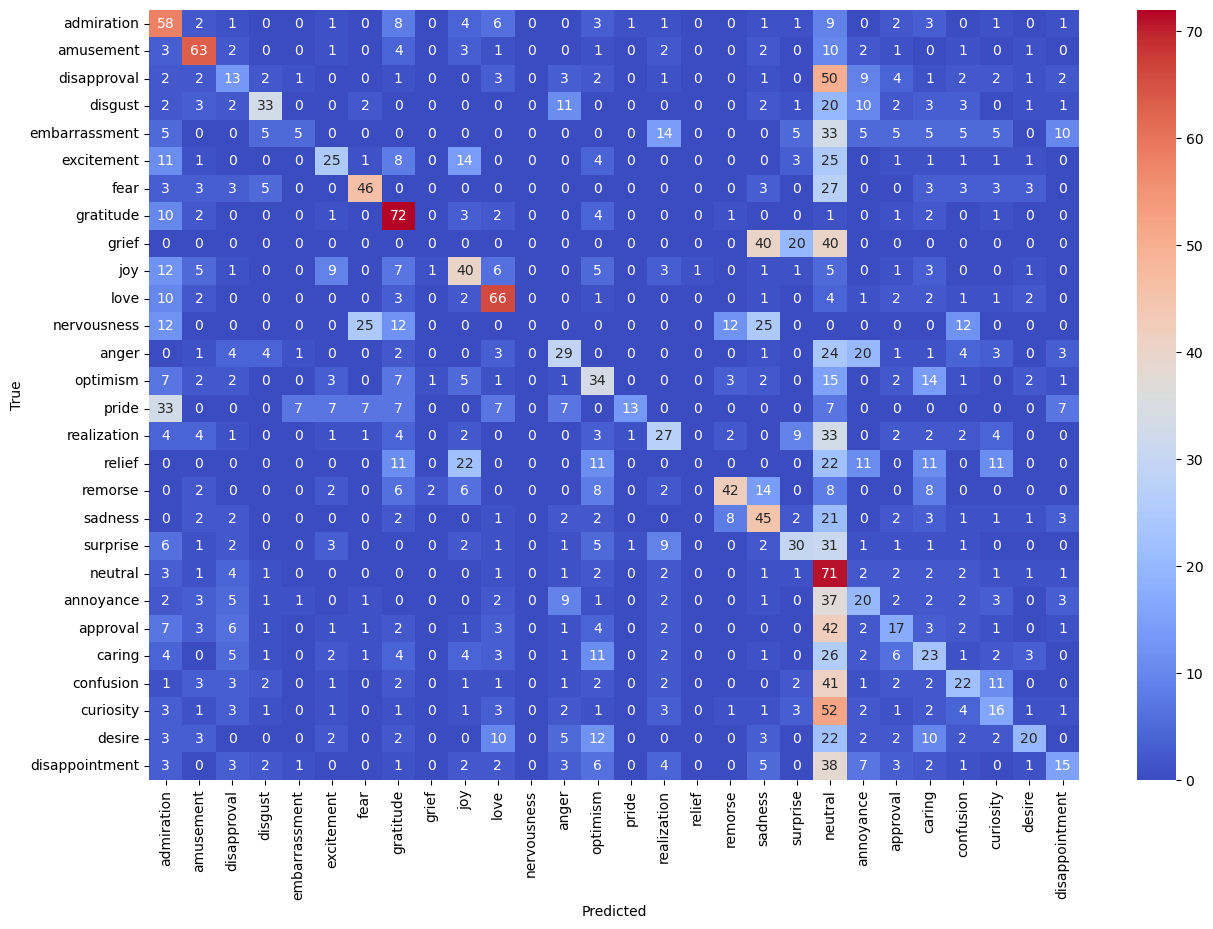

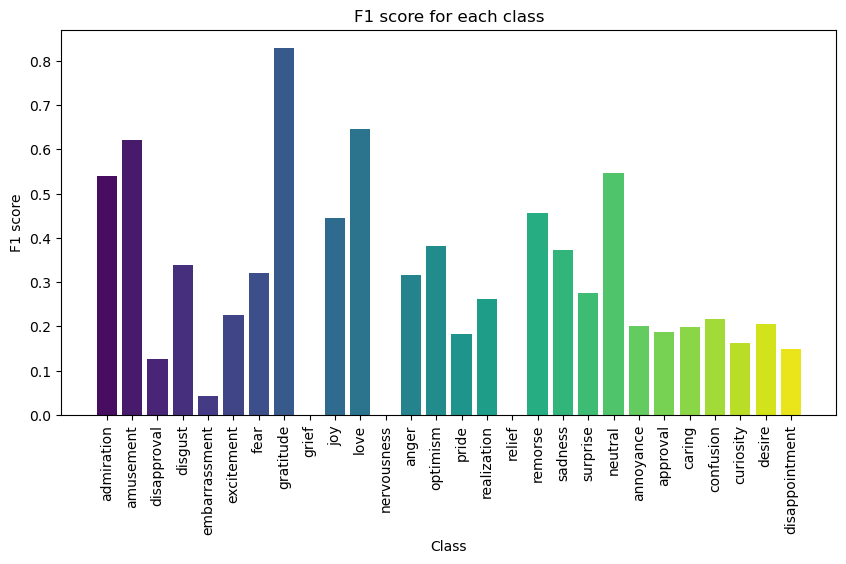

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.66                0.46                0.54                0.37                 504
amusement                           0.79                0.51                0.62                0.45                 264
disapproval                         0.20                0.09                0.13                0.07                 267
disgust                             0.60                0.24                0.34                0.20                 123
embarrassment                       0.10                0.03                0.04                0.02                  37
excitement                          0.32                0.17                0.23                0.13                 103
fear                                0.61                0.22                0.32                0.19                  78
gratitude

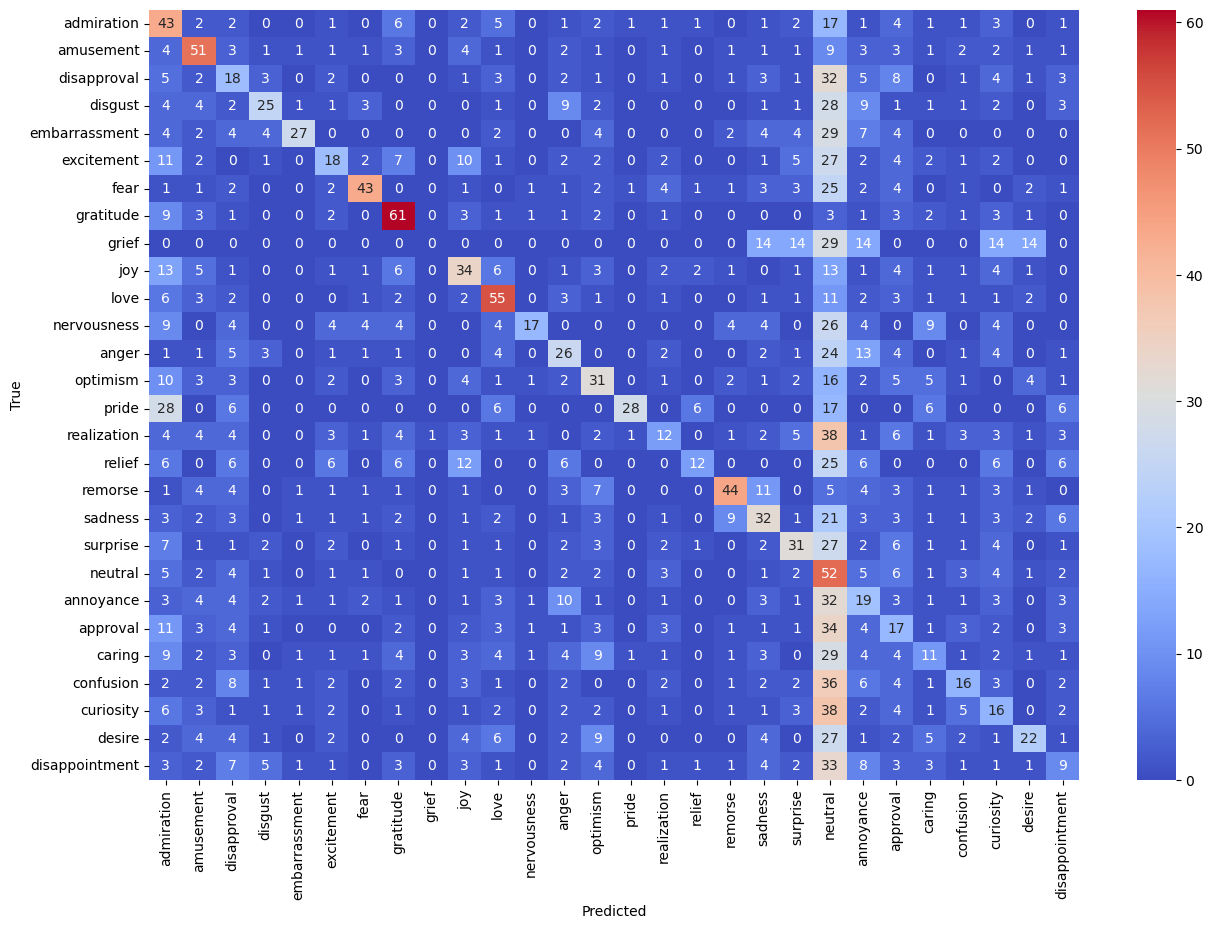

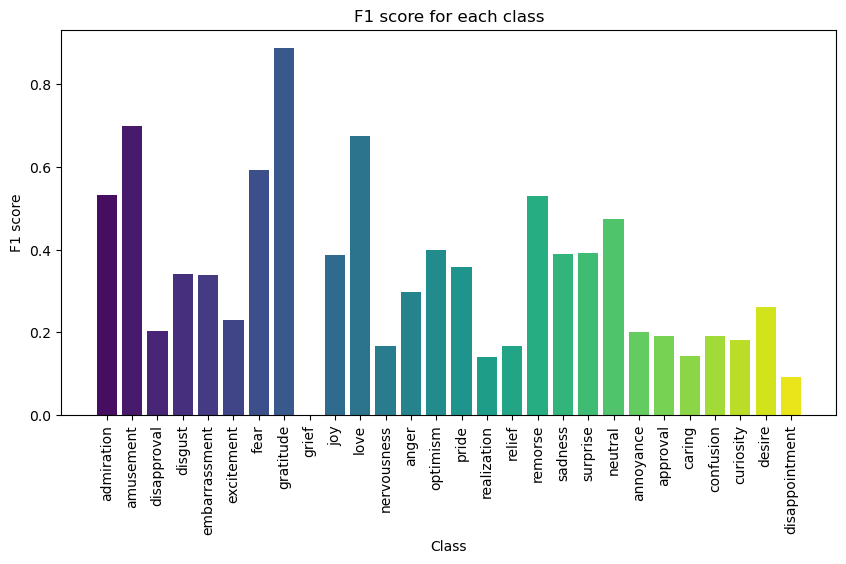

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.53                0.54                0.53                0.36                 504
amusement                           0.69                0.70                0.70                0.54                 264
disapproval                         0.22                0.19                0.20                0.11                 267
disgust                             0.44                0.28                0.34                0.20                 123
embarrassment                       0.35                0.32                0.34                0.20                  37
excitement                          0.26                0.20                0.23                0.13                 103
fear                                0.60                0.59                0.59                0.42                  78
gratitude

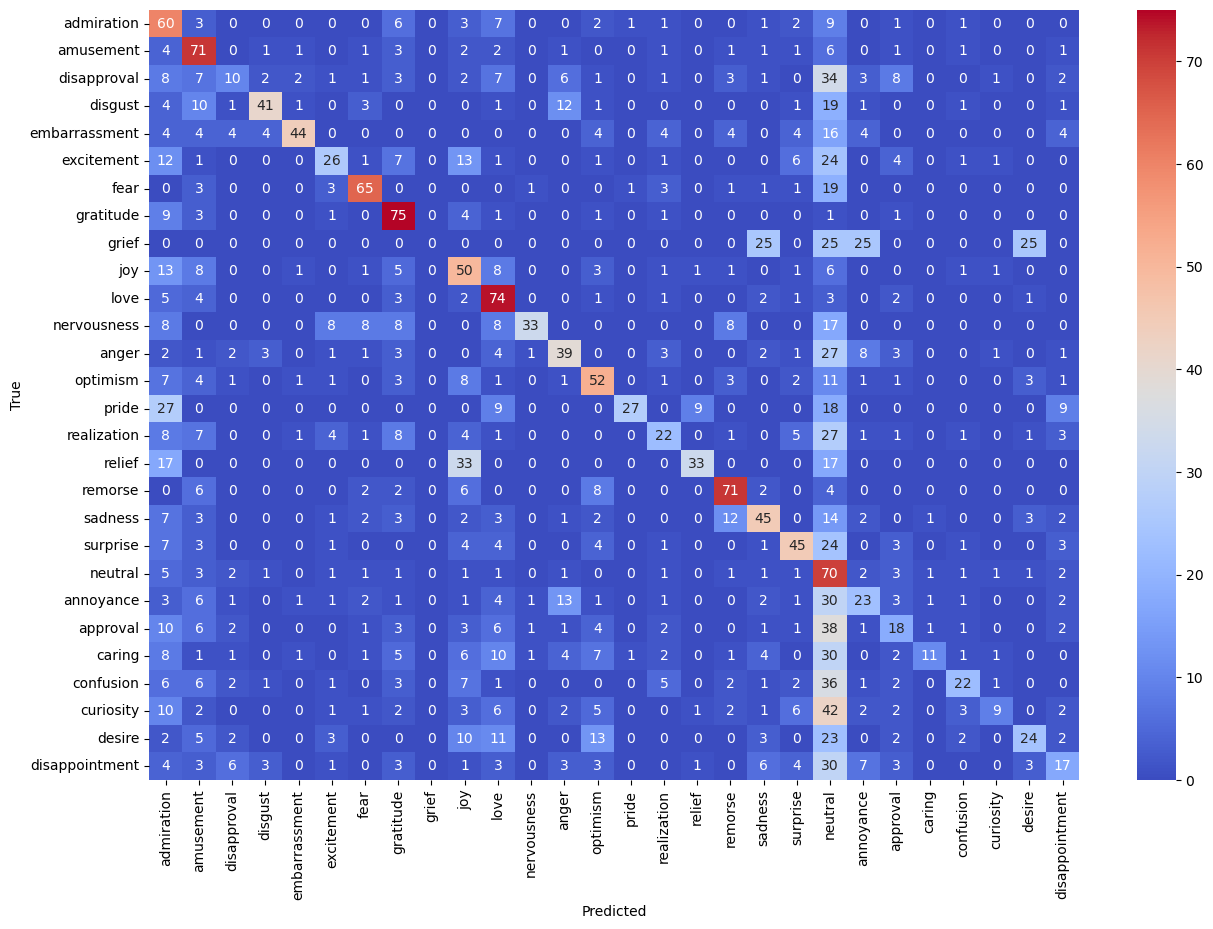

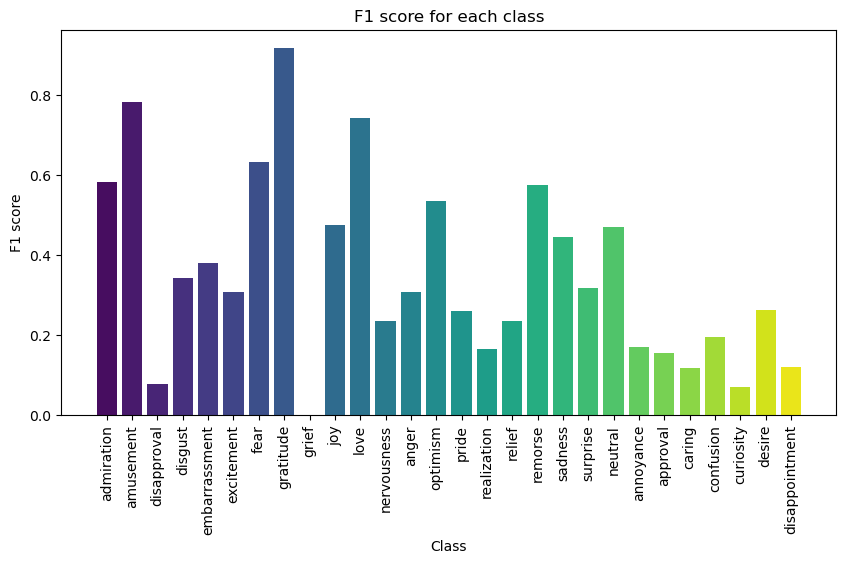

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.64                0.53                0.58                0.41                 504
amusement                           0.76                0.81                0.78                0.64                 264
disapproval                         0.27                0.04                0.08                0.04                 267
disgust                             0.70                0.23                0.34                0.21                 123
embarrassment                       0.52                0.30                0.38                0.23                  37
excitement                          0.55                0.21                0.31                0.18                 103
fear                                0.72                0.56                0.63                0.46                  78
gratitude

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


----------------------------------------------------------------------
Model: Bert
Dataset: GoEmotions


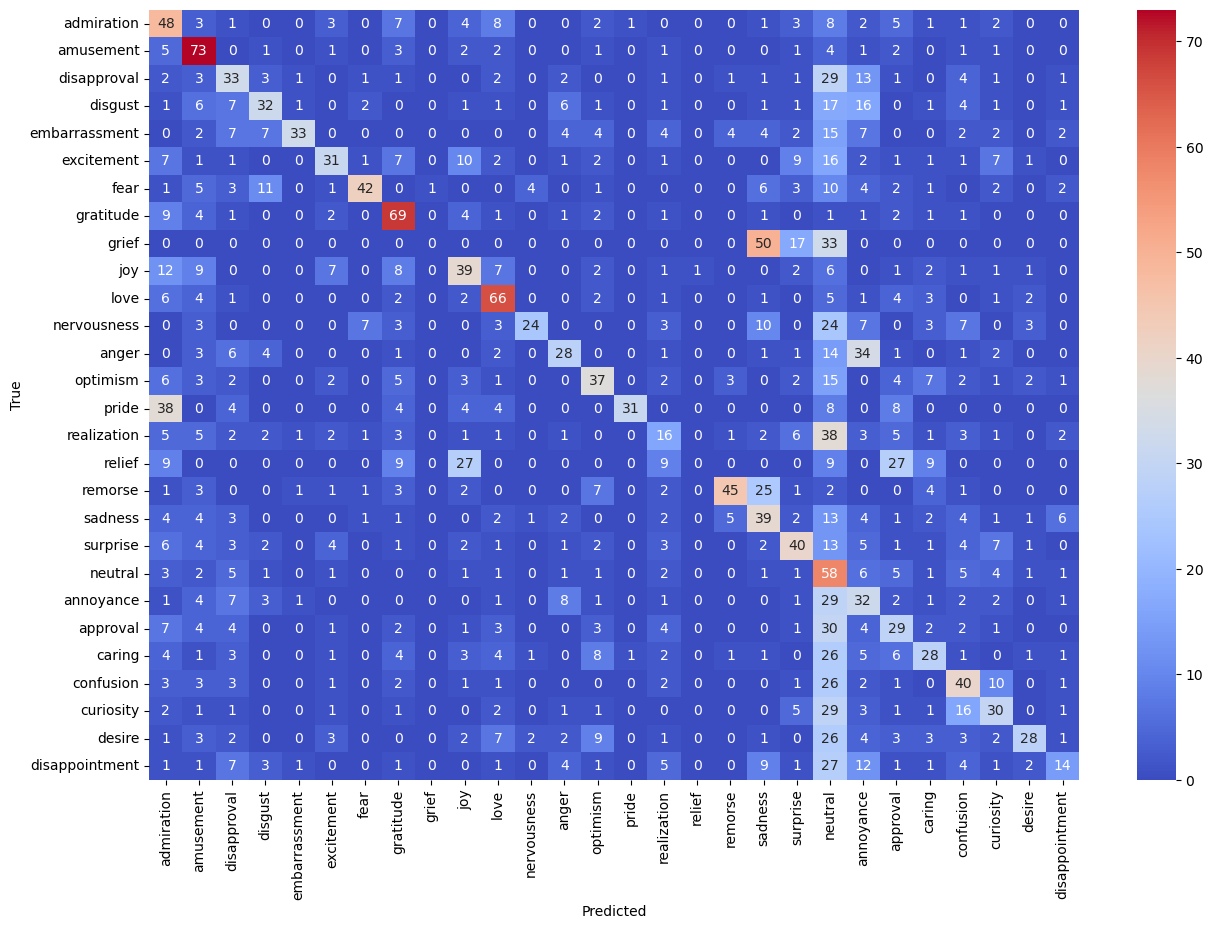

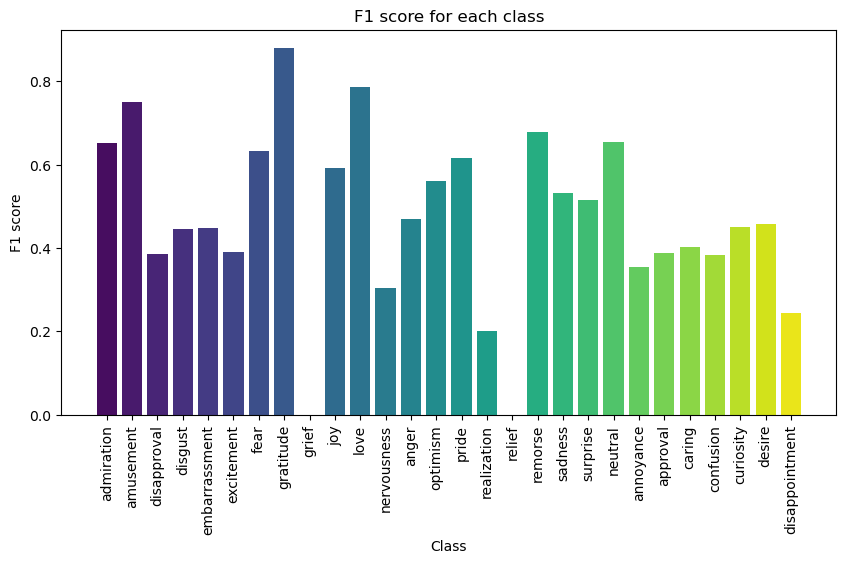

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.63                0.67                0.65                0.48                 504
amusement                           0.62                0.94                0.75                0.60                 264
disapproval                         0.35                0.43                0.39                0.24                 267
disgust                             0.46                0.43                0.45                0.29                 123
embarrassment                       0.50                0.41                0.45                0.29                  37
excitement                          0.35                0.45                0.39                0.24                 103
fear                                0.76                0.54                0.63                0.46                  78
gratitude

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------
Model: Roberta
Dataset: GoEmotions


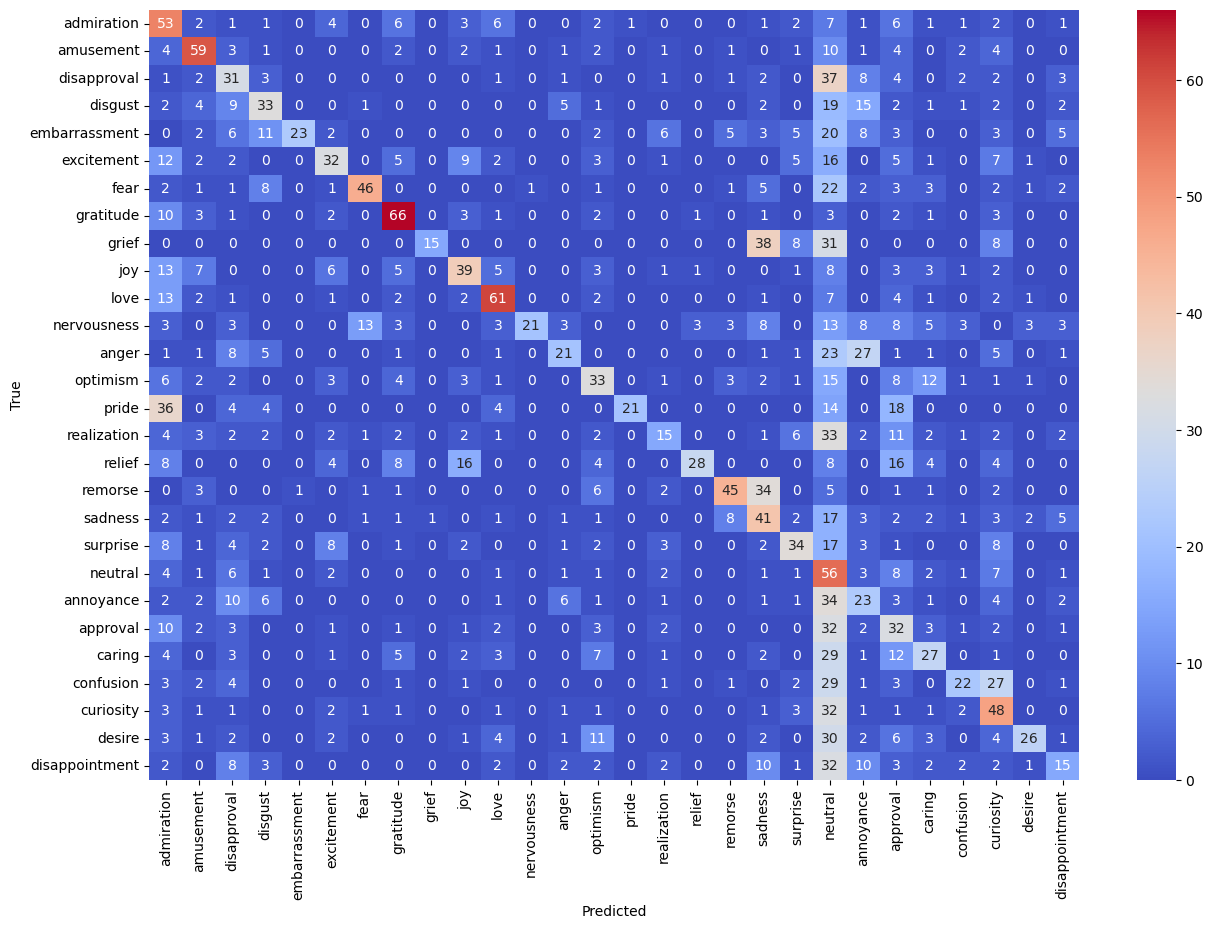

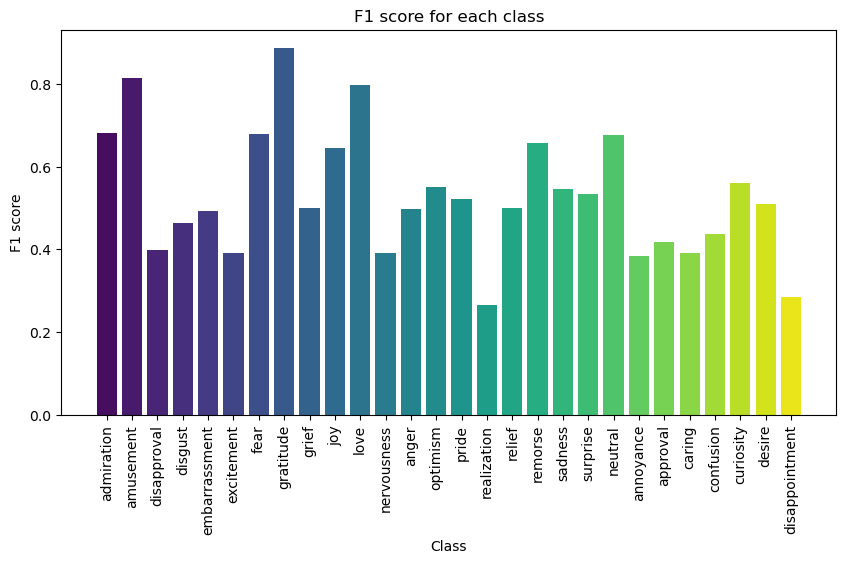

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.58                0.83                0.68                0.52                 504
amusement                           0.73                0.92                0.81                0.69                 264
disapproval                         0.30                0.58                0.40                0.25                 267
disgust                             0.39                0.58                0.46                0.30                 123
embarrassment                       0.62                0.41                0.49                0.33                  37
excitement                          0.31                0.54                0.39                0.24                 103
fear                                0.71                0.65                0.68                0.52                  78
gratitude

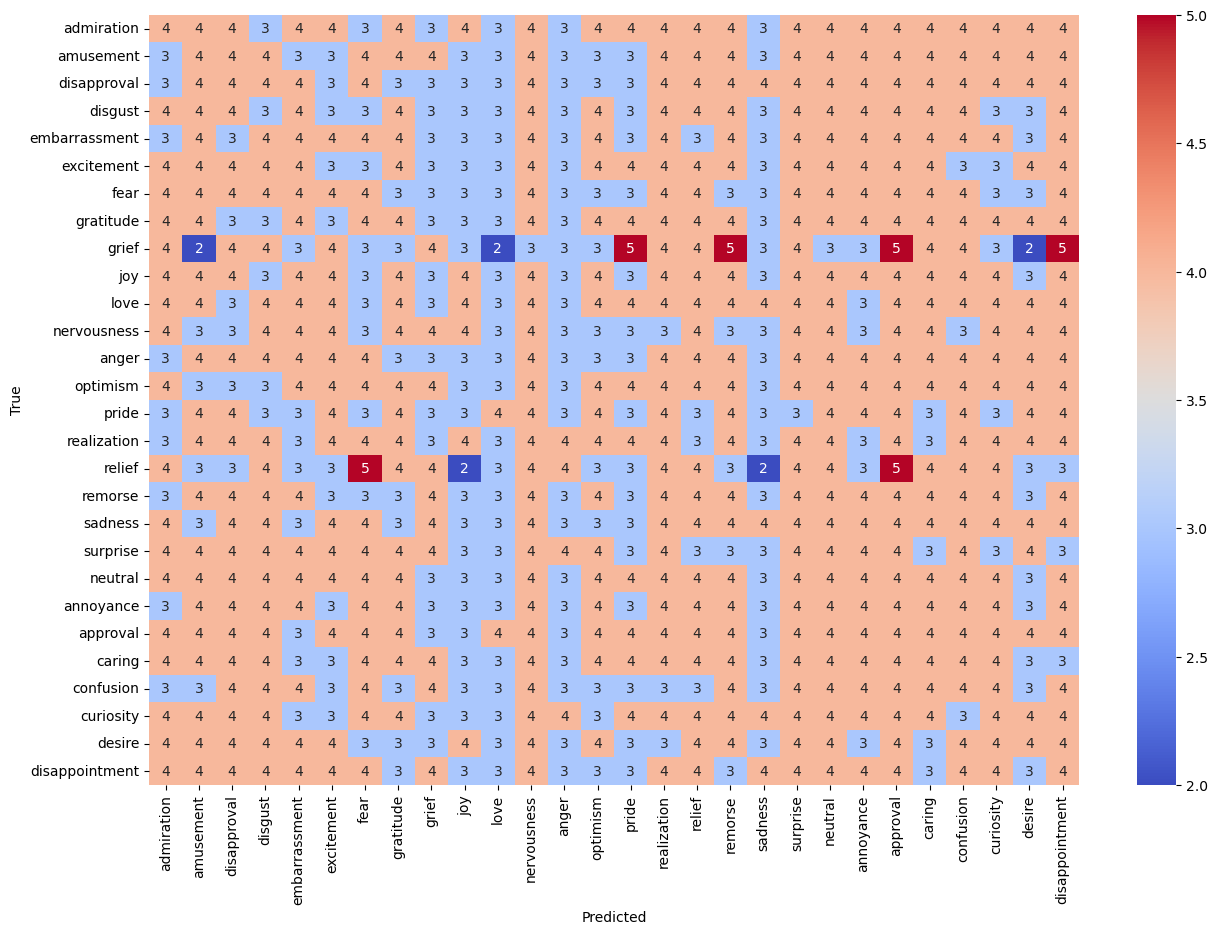

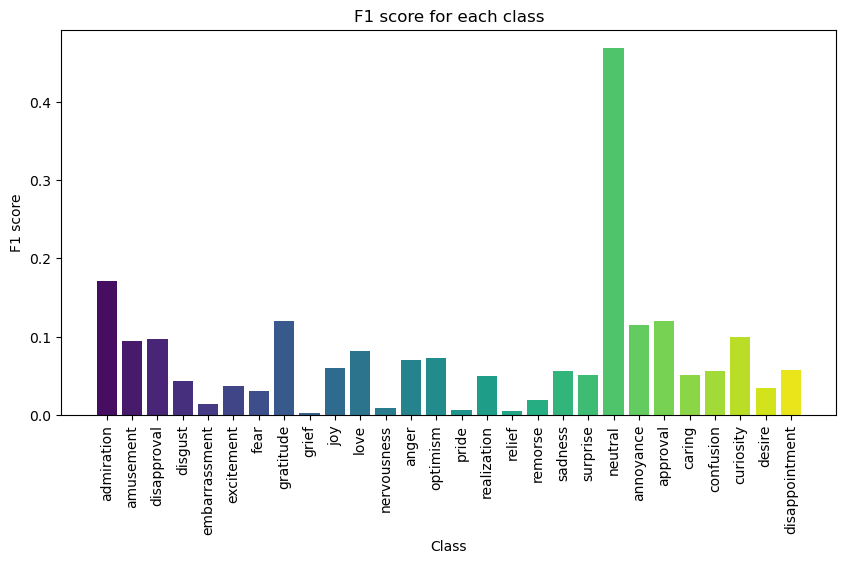

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.10                0.83                0.17                0.09                 504
amusement                           0.05                0.84                0.09                0.05                 264
disapproval                         0.05                0.81                0.10                0.05                 267
disgust                             0.02                0.87                0.05                0.02                 123
embarrassment                       0.01                0.86                0.01                0.01                  37
excitement                          0.02                0.81                0.04                0.02                 103
fear                                0.01                0.81                0.03                0.01                  78
gratitude

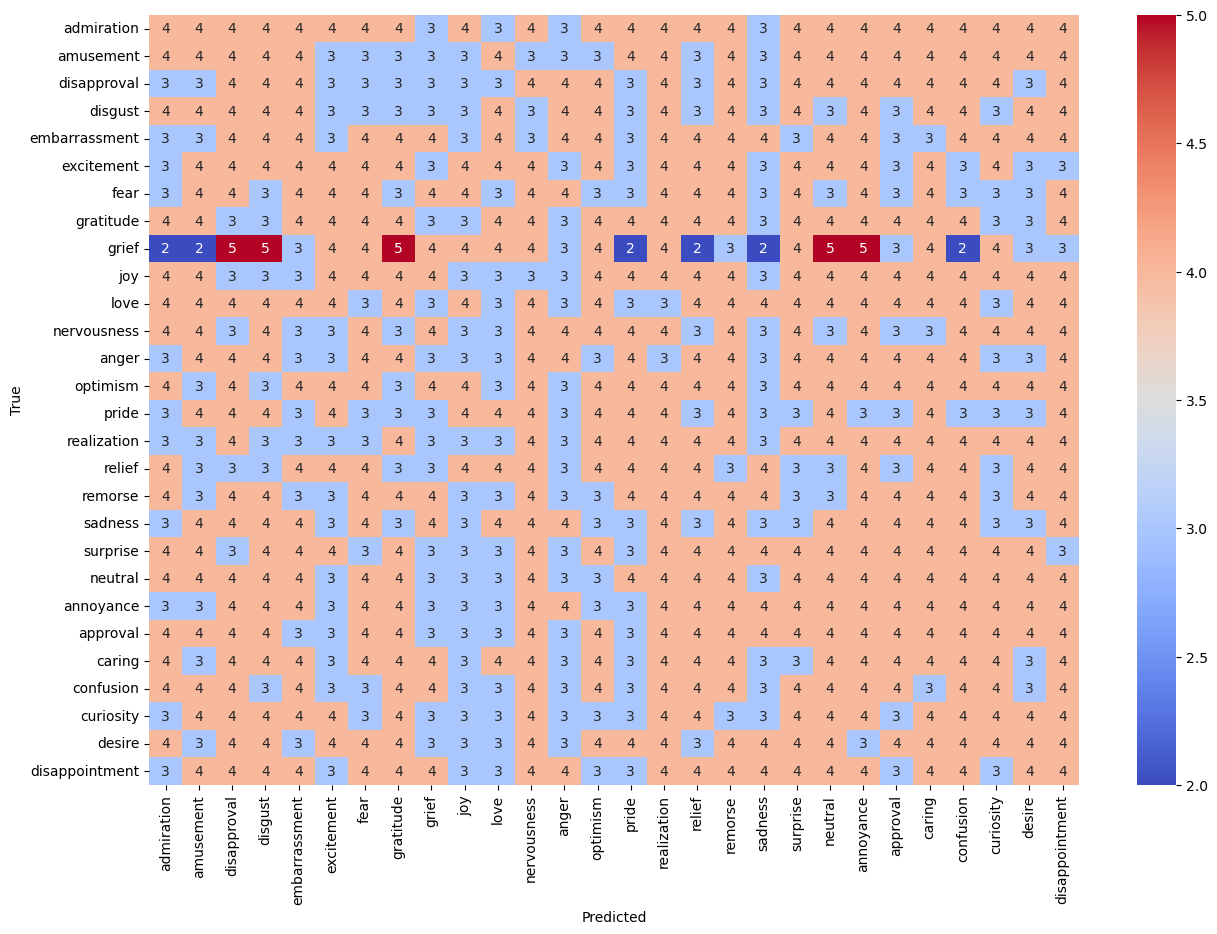

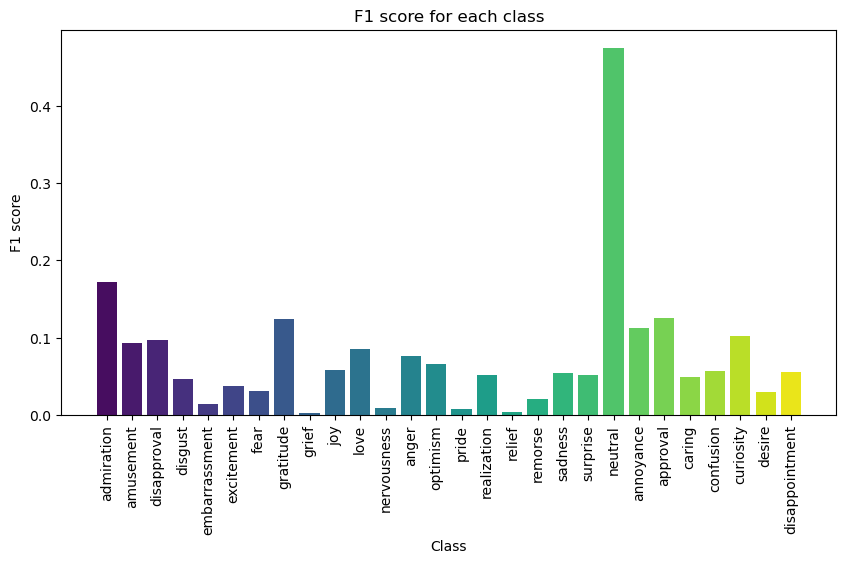

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
admiration                          0.10                0.84                0.17                0.09                 504
amusement                           0.05                0.83                0.09                0.05                 264
disapproval                         0.05                0.81                0.10                0.05                 267
disgust                             0.02                0.89                0.05                0.02                 123
embarrassment                       0.01                0.78                0.01                0.01                  37
excitement                          0.02                0.83                0.04                0.02                 103
fear                                0.01                0.74                0.02                0.01                  78
gratitude

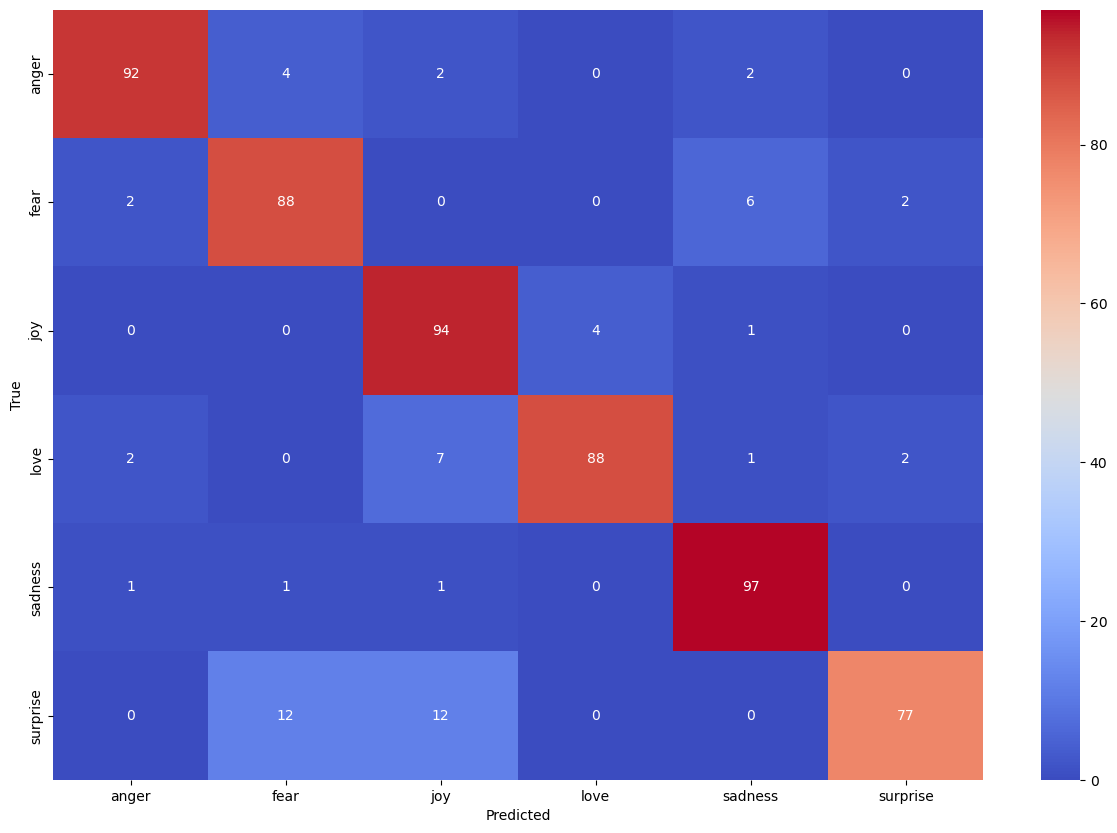

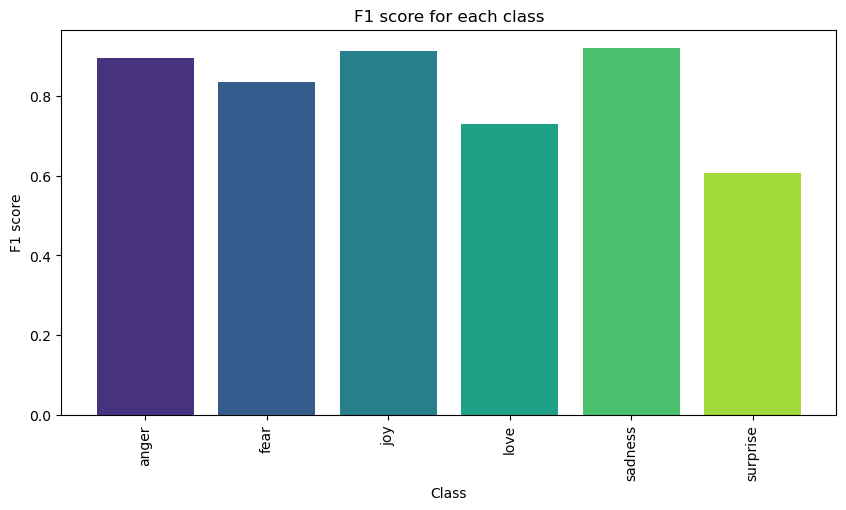

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.94                0.86                0.90                0.81                 275
fear                                0.89                0.79                0.83                0.72                 224
joy                                 0.96                0.86                0.91                0.84                 695
love                                0.80                0.67                0.73                0.58                 159
sadness                             0.96                0.89                0.92                0.85                 581
surprise                            0.77                0.50                0.61                0.43                  66
Macro avg                           0.89                0.76                0.82                0.70                2000
Micro avg

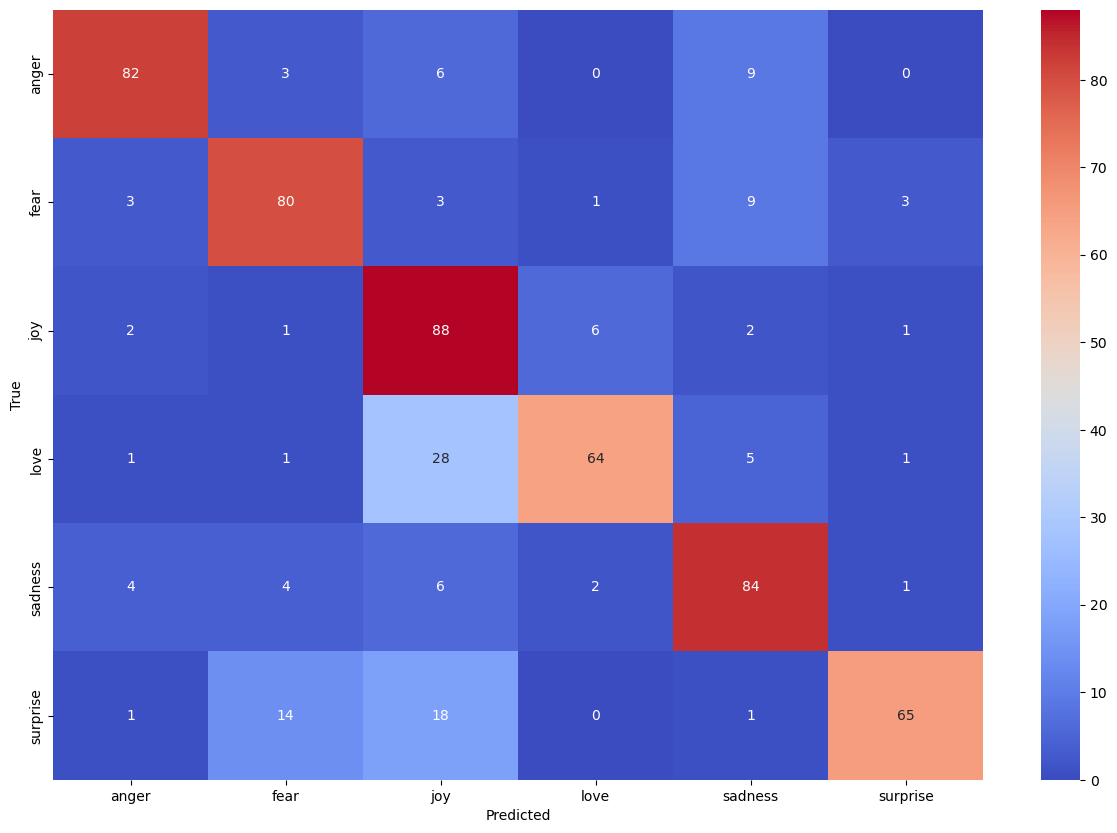

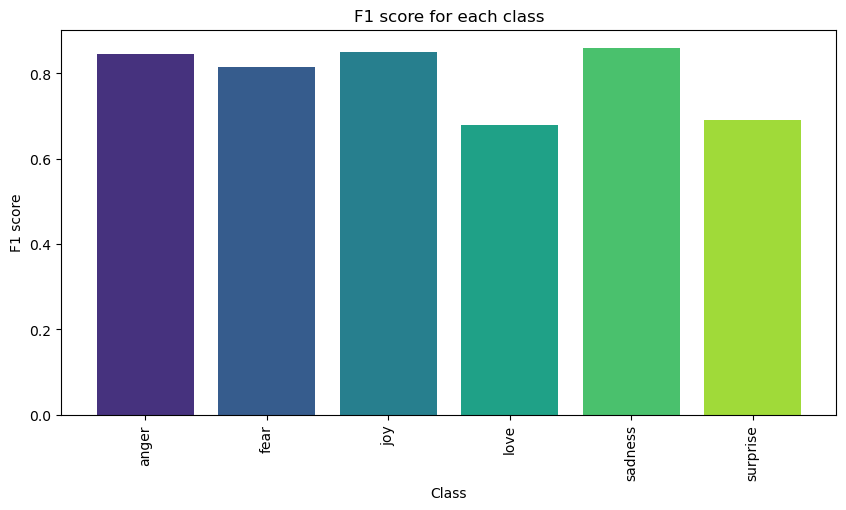

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.84                0.85                0.85                0.73                 275
fear                                0.80                0.83                0.81                0.69                 224
joy                                 0.83                0.86                0.85                0.74                 695
love                                0.67                0.69                0.68                0.51                 159
sadness                             0.87                0.85                0.86                0.75                 581
surprise                            0.67                0.71                0.69                0.53                  66
Macro avg                           0.78                0.80                0.79                0.66                2000
Micro avg

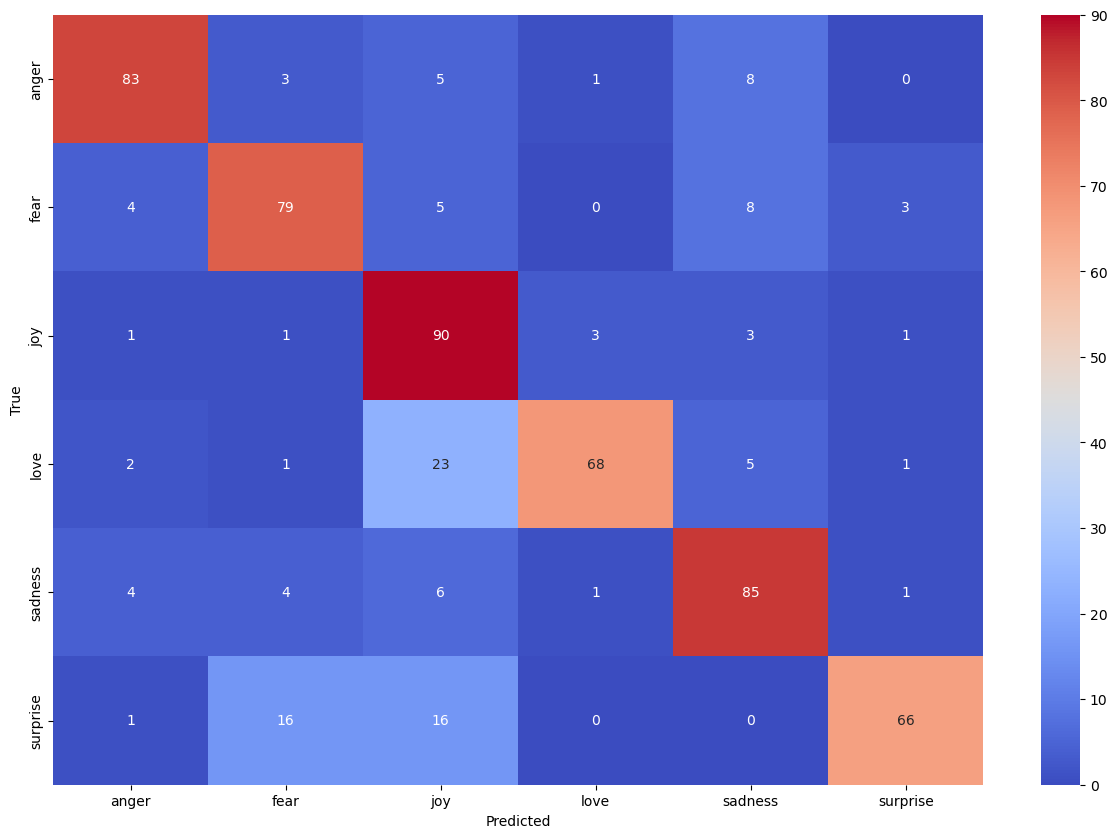

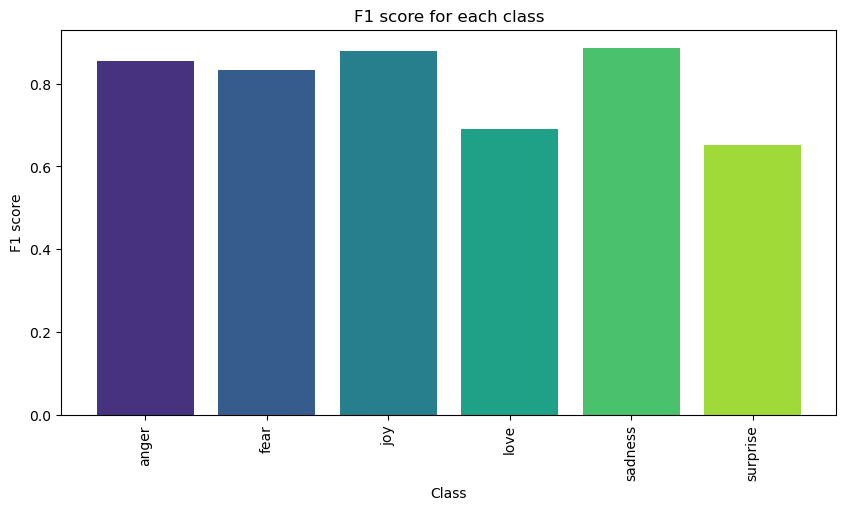

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.84                0.87                0.86                0.75                 275
fear                                0.80                0.87                0.83                0.71                 224
joy                                 0.85                0.91                0.88                0.78                 695
love                                0.74                0.64                0.69                0.53                 159
sadness                             0.88                0.89                0.89                0.80                 581
surprise                            0.64                0.67                0.65                0.48                  66
Macro avg                           0.79                0.81                0.80                0.68                2000
Micro avg

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


----------------------------------------------------------------------
Model: Bert
Dataset: TwitterData


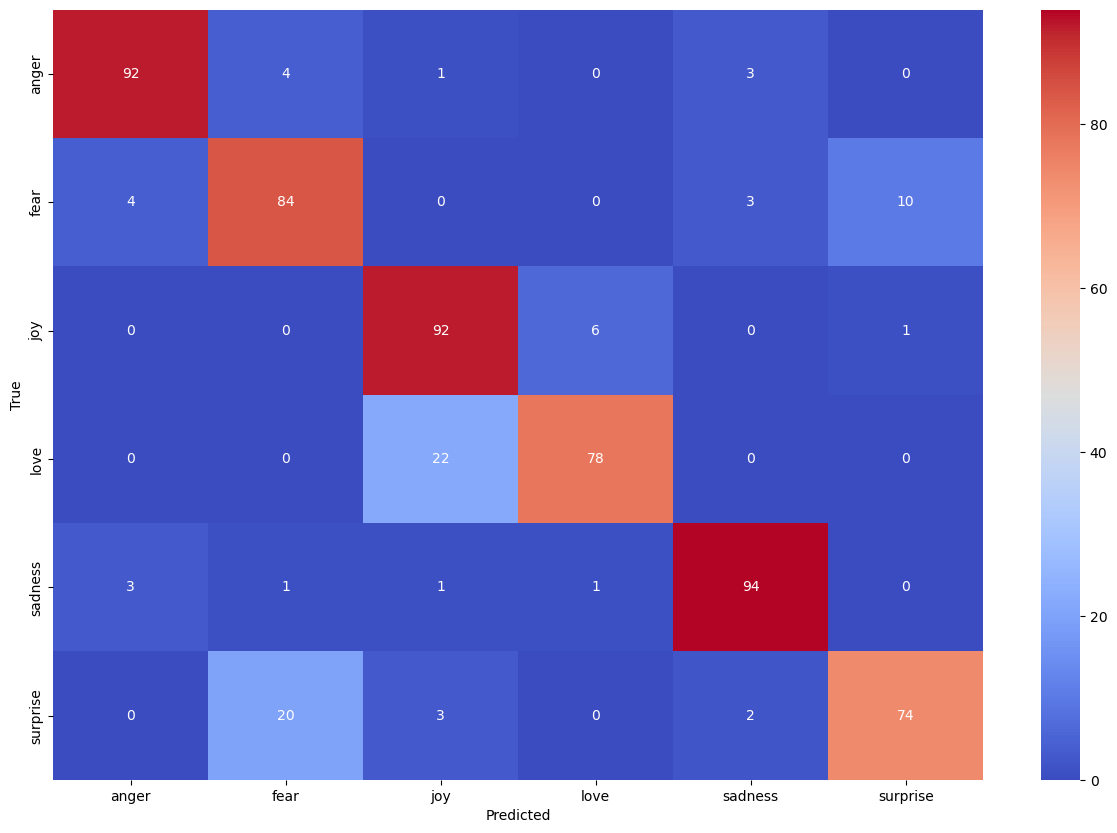

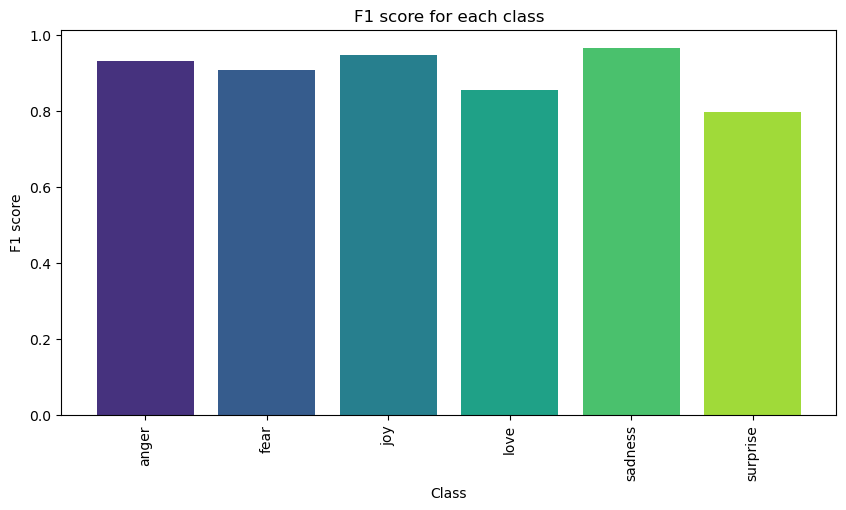

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.89                0.97                0.93                0.87                 275
fear                                0.85                0.96                0.91                0.83                 224
joy                                 0.92                0.97                0.95                0.90                 695
love                                0.76                0.97                0.85                0.75                 159
sadness                             0.96                0.97                0.96                0.93                 581
surprise                            0.67                0.97                0.80                0.66                  66
Macro avg                           0.84                0.97                0.90                0.82                2000
Micro avg

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------
Model: Roberta
Dataset: TwitterData


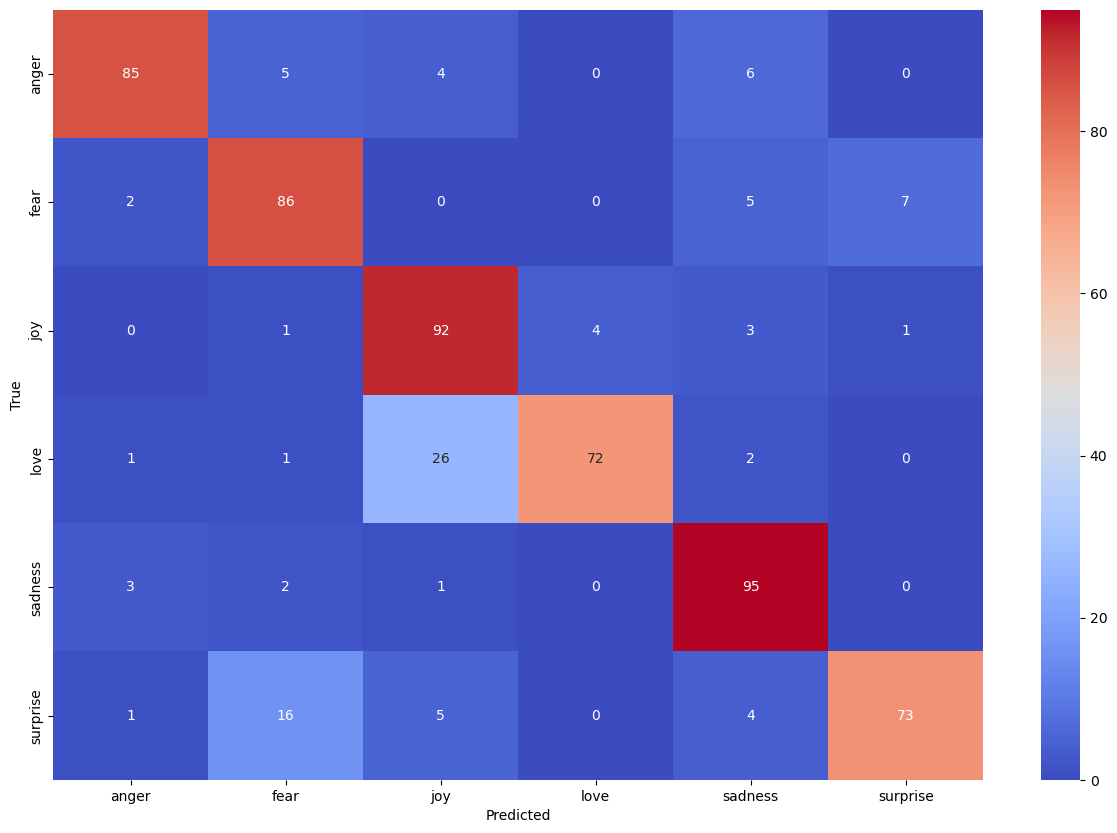

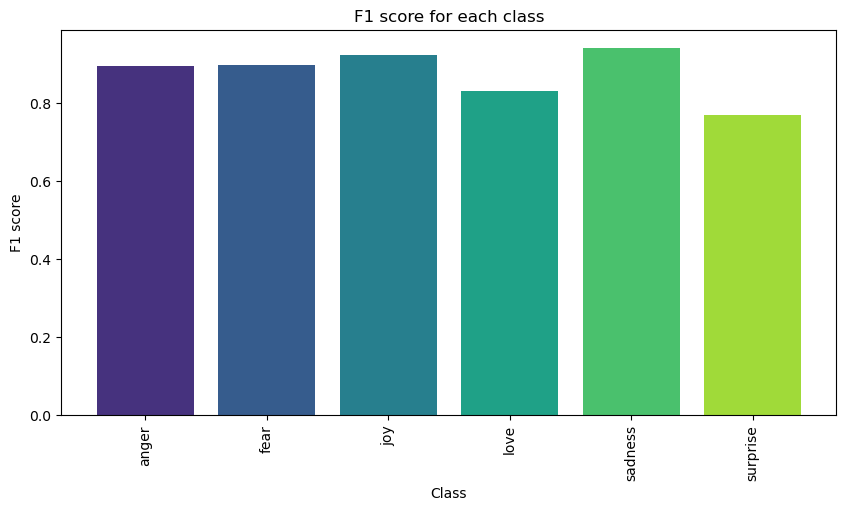

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.91                0.88                0.89                0.81                 275
fear                                0.84                0.96                0.90                0.81                 224
joy                                 0.90                0.94                0.92                0.86                 695
love                                0.83                0.82                0.83                0.71                 159
sadness                             0.91                0.97                0.94                0.89                 581
surprise                            0.71                0.83                0.77                0.62                  66
Macro avg                           0.85                0.90                0.88                0.78                2000
Micro avg

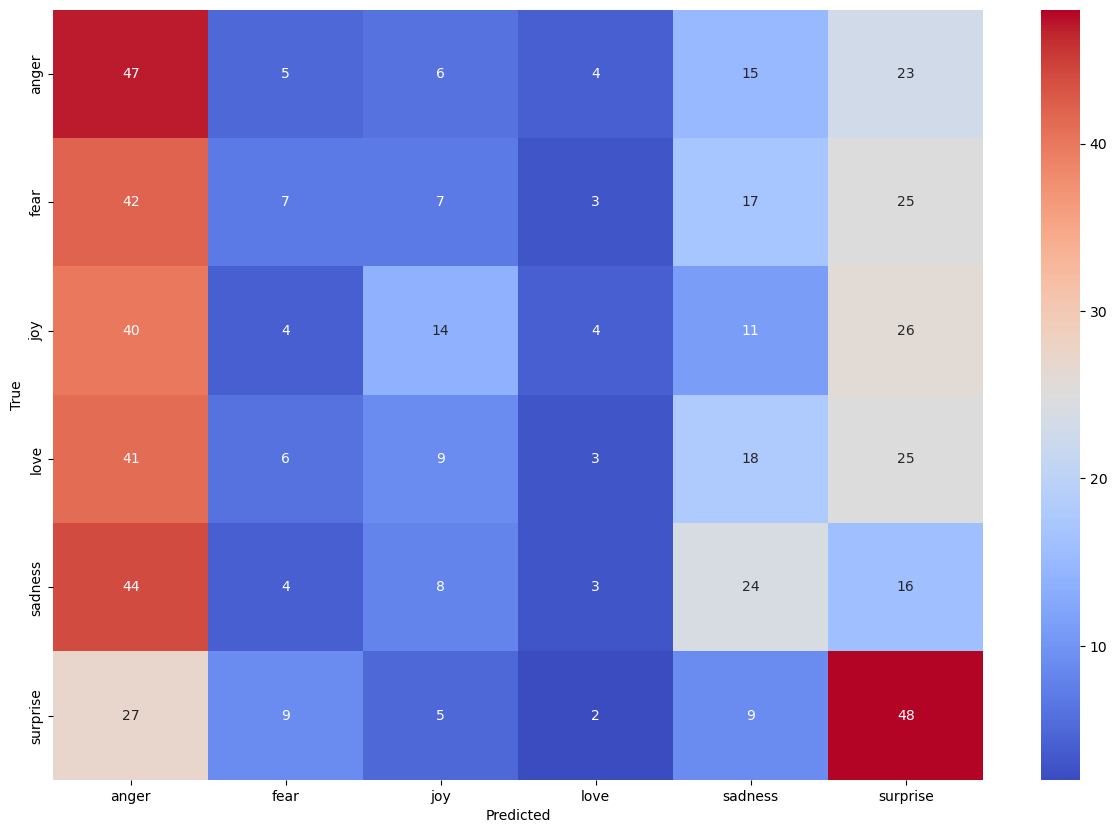

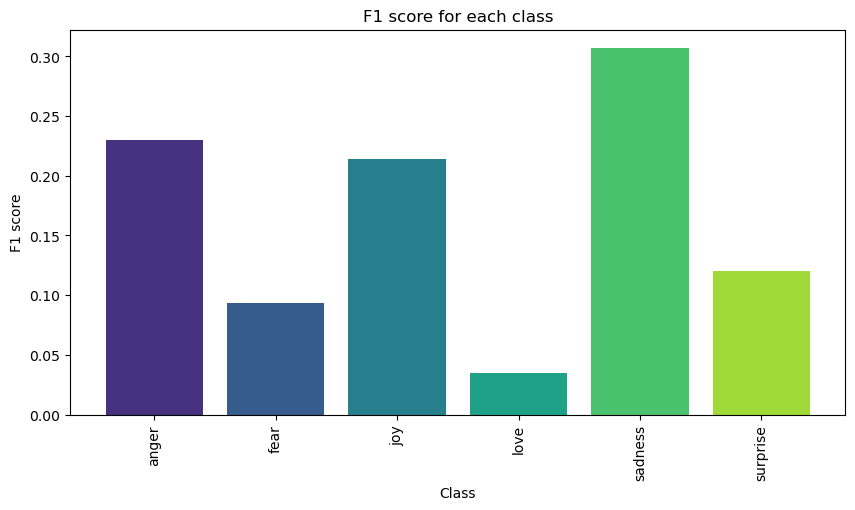

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.15                0.47                0.23                0.13                 275
fear                                0.15                0.07                0.09                0.05                 224
joy                                 0.49                0.14                0.21                0.12                 695
love                                0.06                0.03                0.03                0.02                 159
sadness                             0.42                0.24                0.31                0.18                 581
surprise                            0.07                0.48                0.12                0.06                  66
Macro avg                           0.22                0.24                0.17                0.09                2000
Micro avg

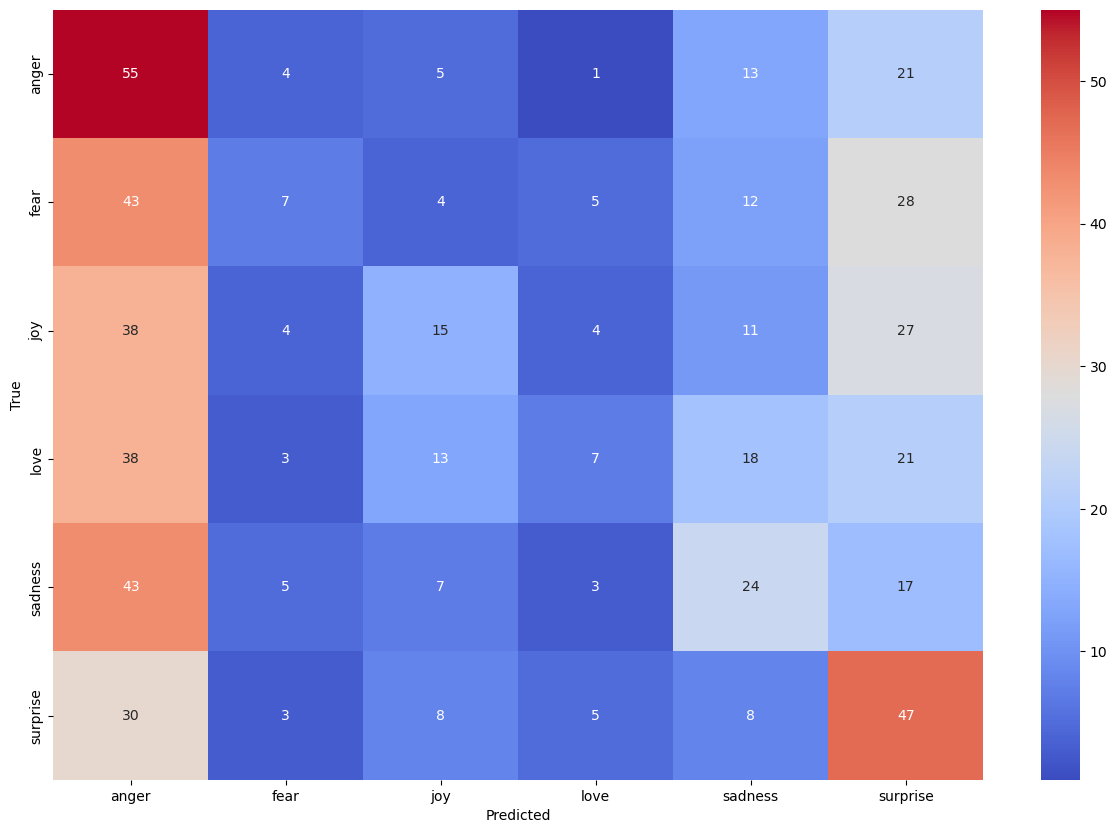

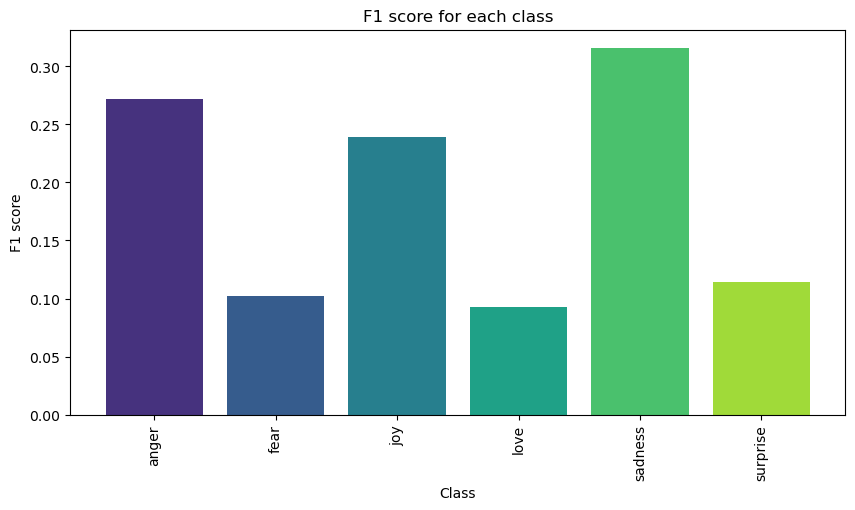

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
anger                               0.18                0.55                0.27                0.16                 275
fear                                0.18                0.07                0.10                0.05                 224
joy                                 0.55                0.15                0.24                0.14                 695
love                                0.14                0.07                0.09                0.05                 159
sadness                             0.45                0.24                0.32                0.19                 581
surprise                            0.06                0.47                0.11                0.06                  66
Macro avg                           0.26                0.26                0.19                0.11                2000
Micro avg

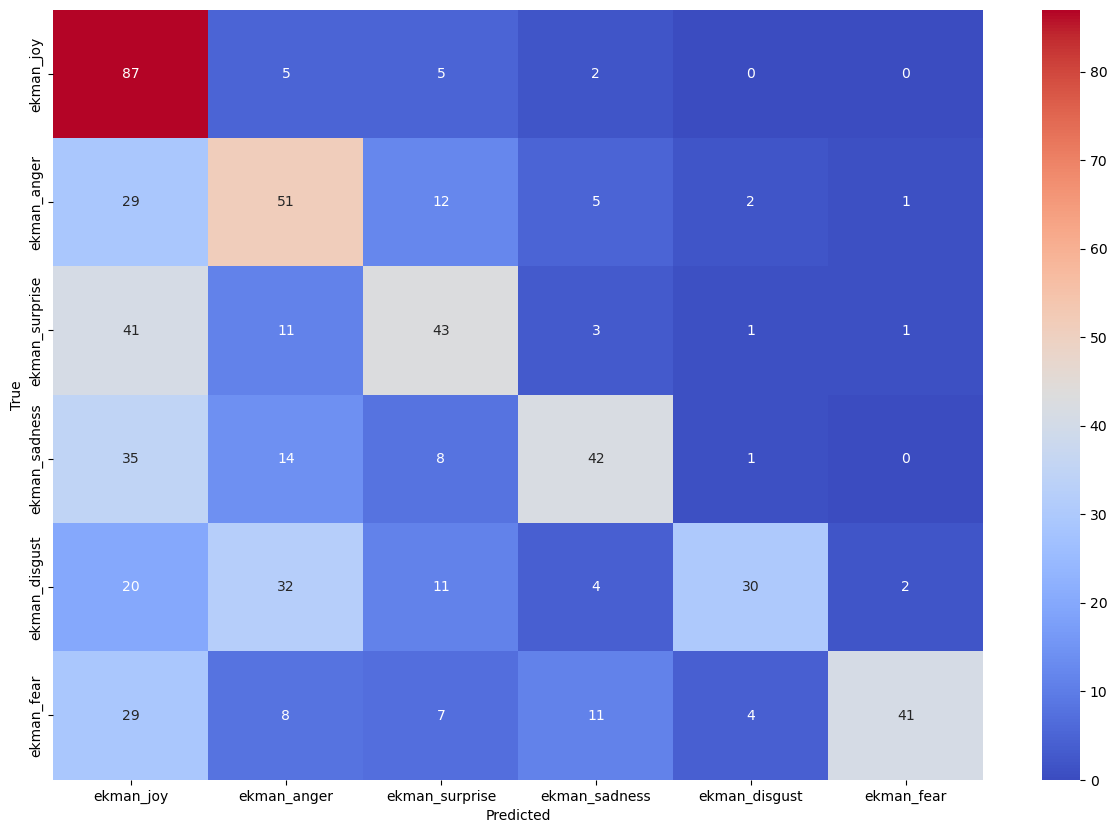

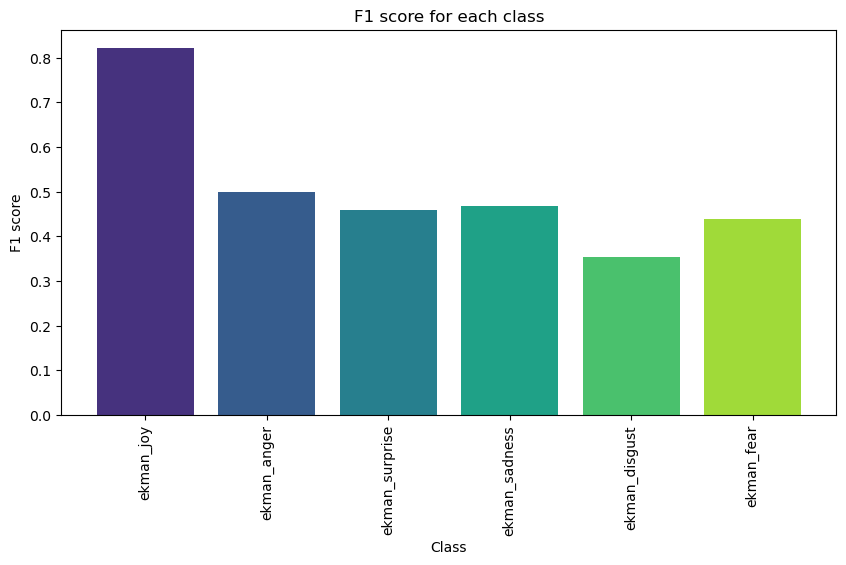

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
ekman_joy                           0.80                0.84                0.82                0.70                2104
ekman_anger                         0.60                0.43                0.50                0.33                 726
ekman_surprise                      0.59                0.38                0.46                0.30                 677
ekman_sadness                       0.63                0.37                0.47                0.31                 379
ekman_disgust                       0.55                0.26                0.35                0.21                 123
ekman_fear                          0.72                0.32                0.44                0.28                  98
Macro avg                           0.65                0.43                0.51                0.36                4107
Micro avg

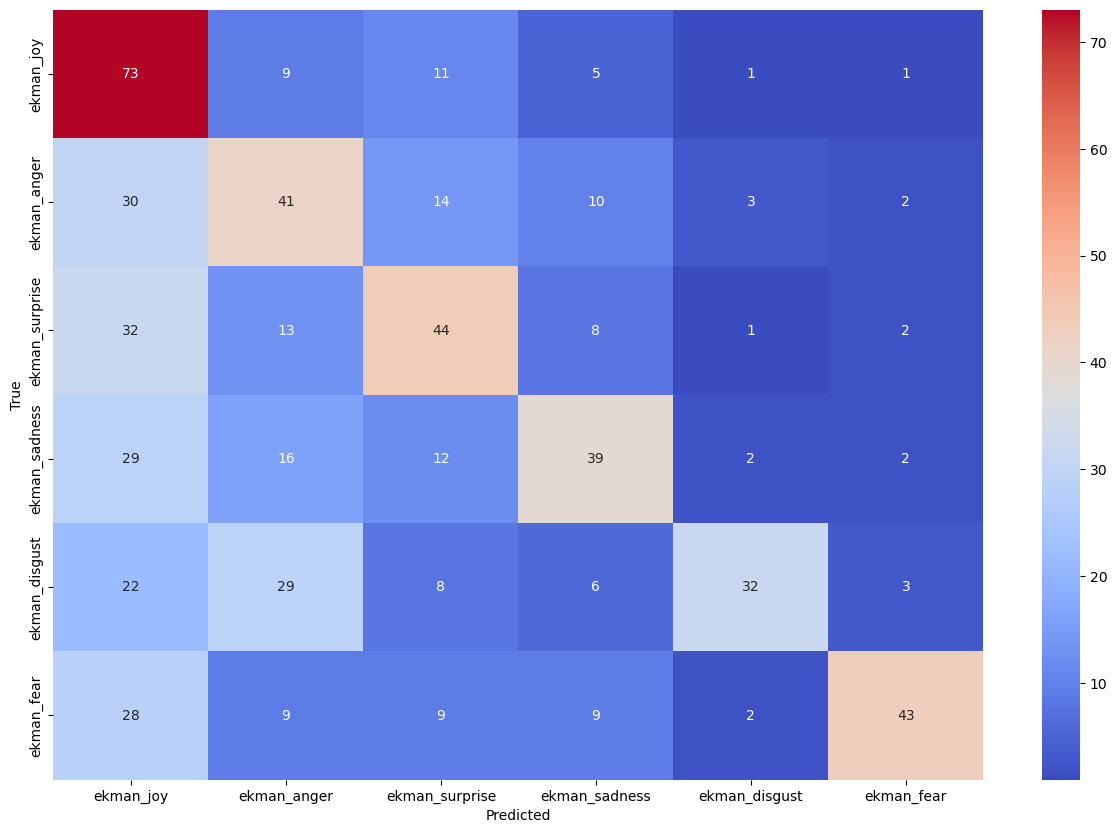

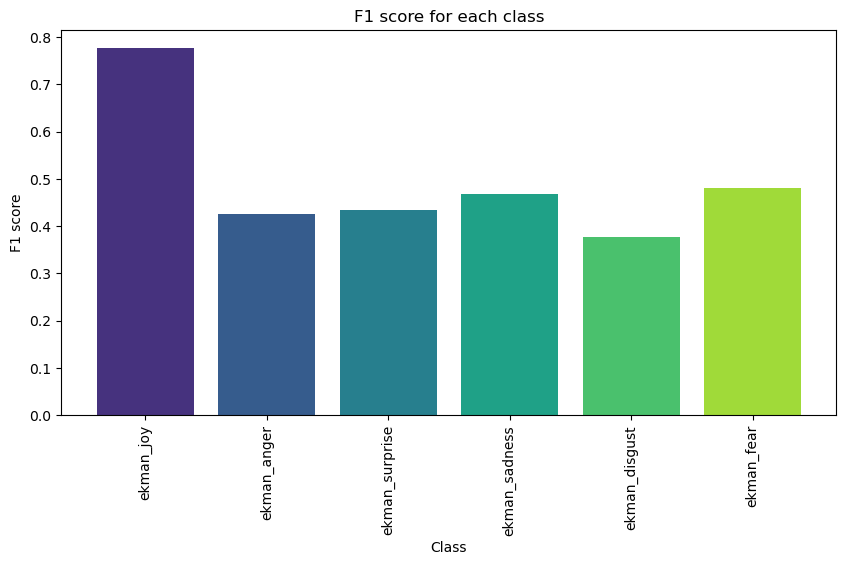

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
ekman_joy                           0.78                0.78                0.78                0.63                2104
ekman_anger                         0.46                0.40                0.43                0.27                 726
ekman_surprise                      0.45                0.42                0.43                0.28                 677
ekman_sadness                       0.48                0.46                0.47                0.30                 379
ekman_disgust                       0.46                0.32                0.38                0.23                 123
ekman_fear                          0.45                0.51                0.48                0.32                  98
Macro avg                           0.51                0.48                0.49                0.34                4107
Micro avg

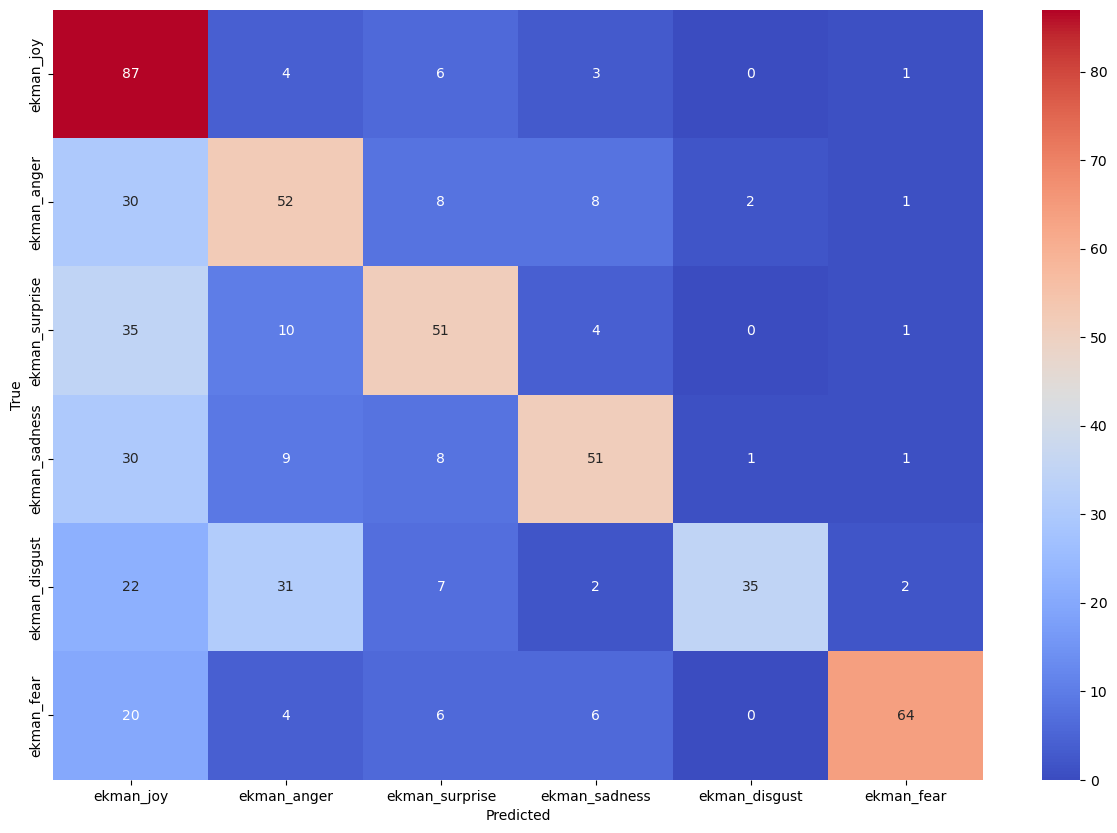

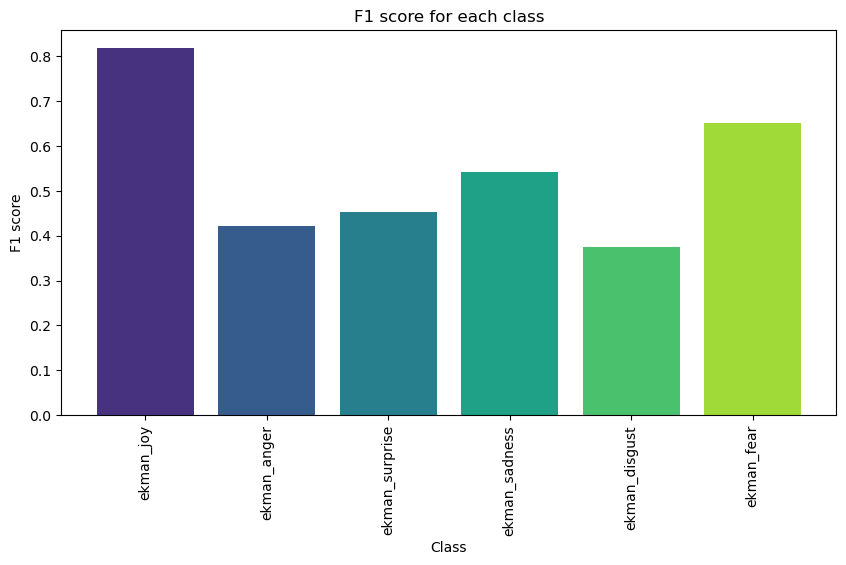

Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
ekman_joy                           0.84                0.79                0.82                0.69                2104
ekman_anger                         0.61                0.32                0.42                0.27                 726
ekman_surprise                      0.65                0.35                0.45                0.29                 677
ekman_sadness                       0.67                0.46                0.54                0.37                 379
ekman_disgust                       0.74                0.25                0.38                0.23                 123
ekman_fear                          0.74                0.58                0.65                0.48                  98
Macro avg                           0.71                0.46                0.54                0.39                4107
Micro avg

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


----------------------------------------------------------------------
Model: Bert
Dataset: GoEmotionsGrouped


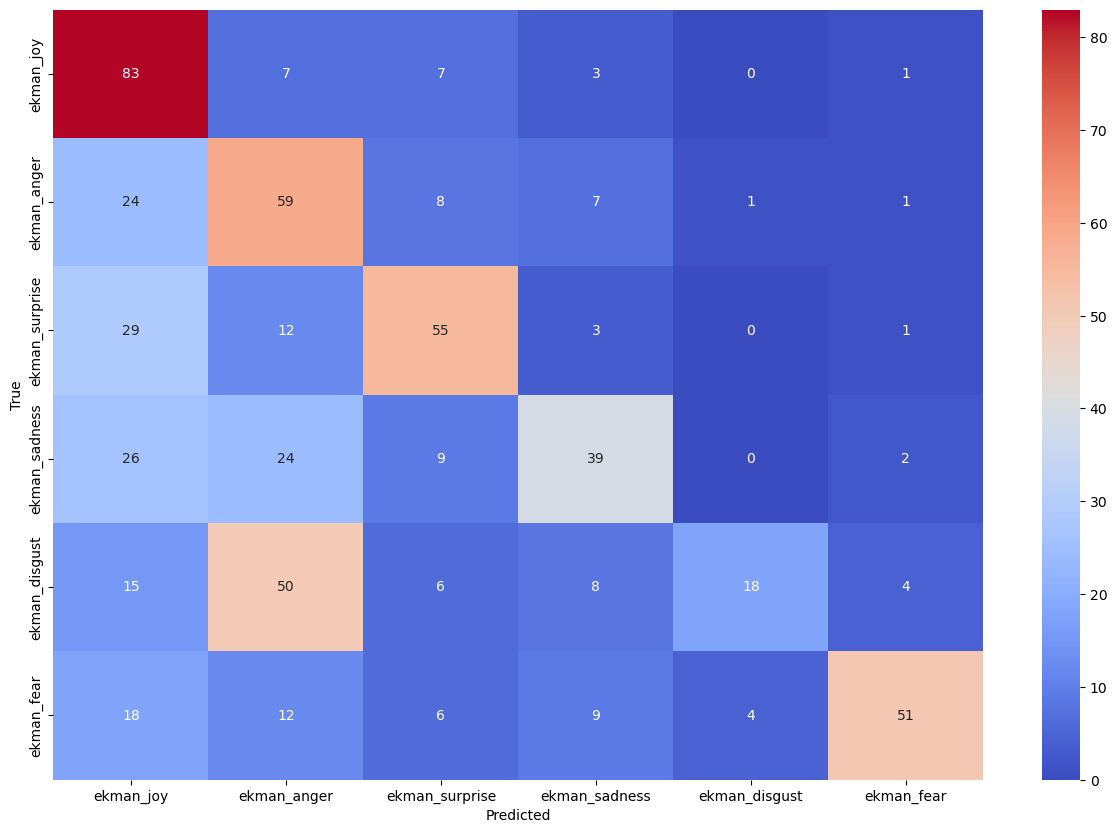

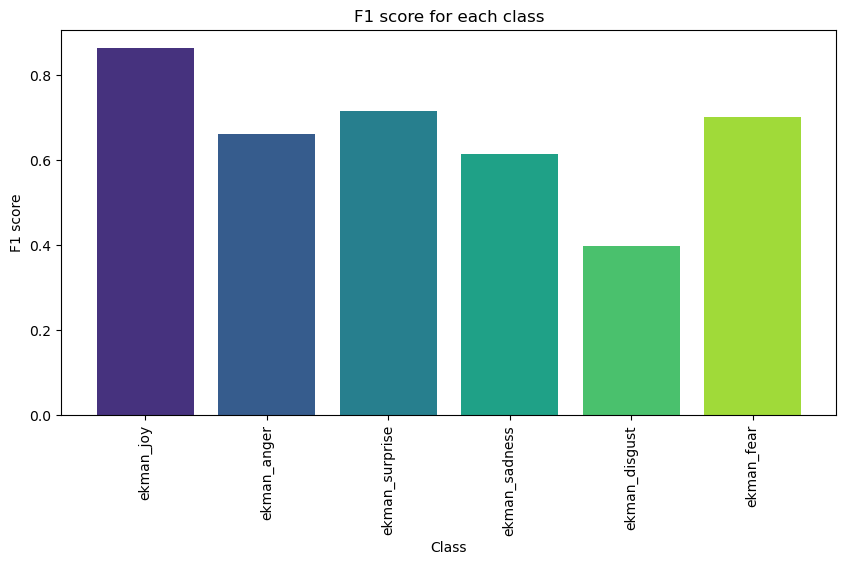

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
ekman_joy                           0.79                0.96                0.86                0.76                2104
ekman_anger                         0.57                0.80                0.66                0.50                 726
ekman_surprise                      0.68                0.75                0.72                0.56                 677
ekman_sadness                       0.62                0.61                0.61                0.44                 379
ekman_disgust                       0.71                0.28                0.40                0.25                 123
ekman_fear                          0.67                0.73                0.70                0.54                  98
Macro avg                           0.67                0.69                0.66                0.51                4107
Micro avg

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------------------------------------------------------------
Model: Roberta
Dataset: GoEmotionsGrouped


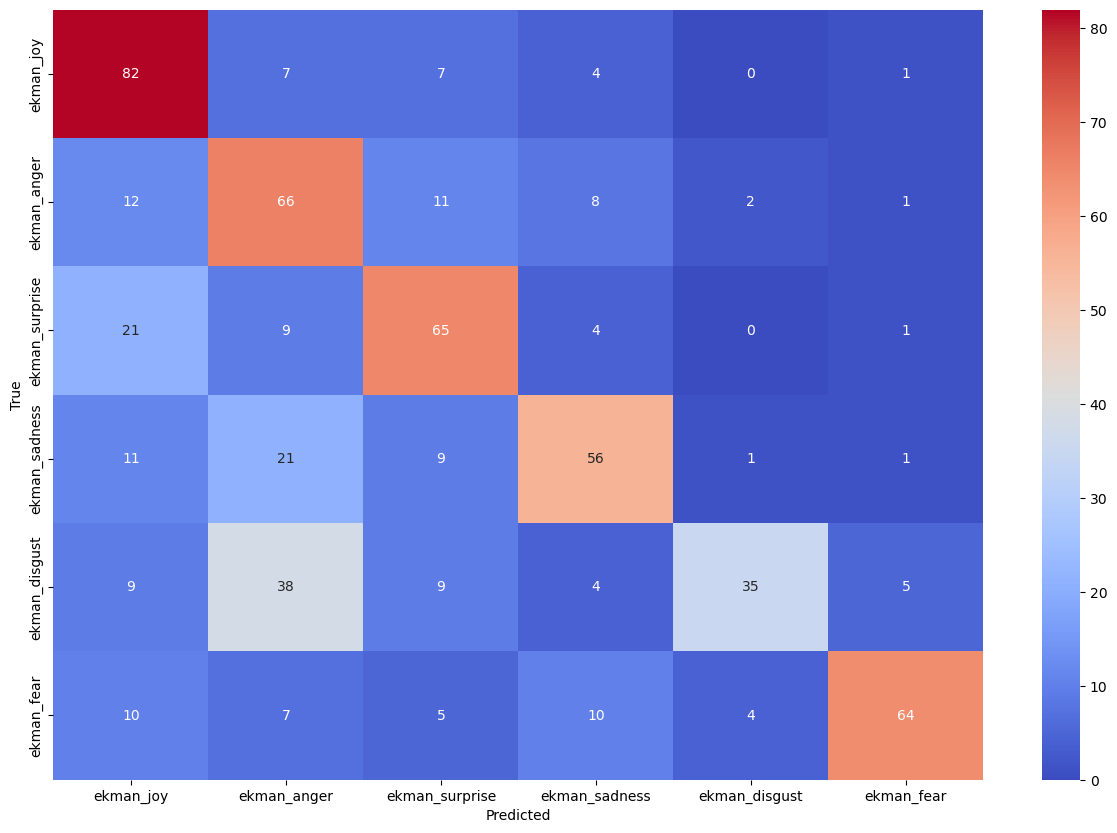

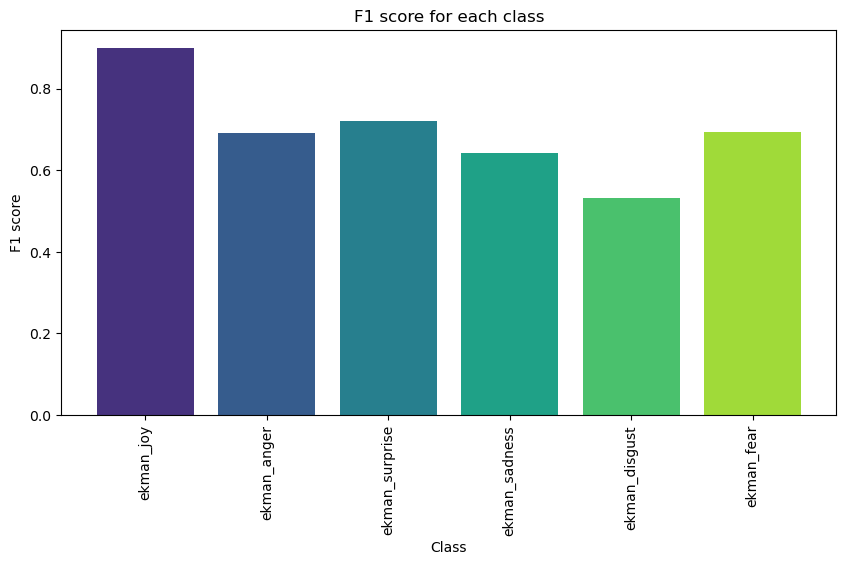

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
Label                          Precision              Recall            F1-Score             Jaccard             Support
ekman_joy                           0.90                0.89                0.90                0.82                2104
ekman_anger                         0.64                0.75                0.69                0.53                 726
ekman_surprise                      0.69                0.75                0.72                0.56                 677
ekman_sadness                       0.63                0.66                0.64                0.47                 379
ekman_disgust                       0.70                0.43                0.53                0.36                 123
ekman_fear                          0.68                0.70                0.69                0.53                  98
Macro avg                           0.71                0.70                0.70                0.55                4107
Micro avg

In [5]:
# print results for all models on all datasets
all_scores = {}
for dataset in DATASETS:
    all_scores[dataset] = print_dataset_results(dataset)

C:\Users\andre\AppData\Local\Temp\ipykernel_16248\191900150.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(print_dict.keys()), y=list(print_dict.values()), palette=sns.color_palette("hls", len(print_dict)))


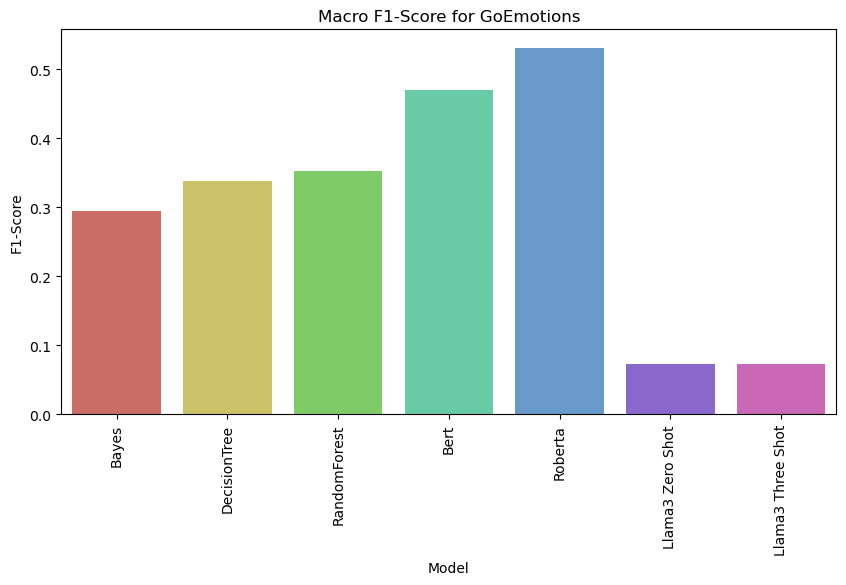

C:\Users\andre\AppData\Local\Temp\ipykernel_16248\191900150.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(print_dict.keys()), y=list(print_dict.values()), palette=sns.color_palette("hls", len(print_dict)))


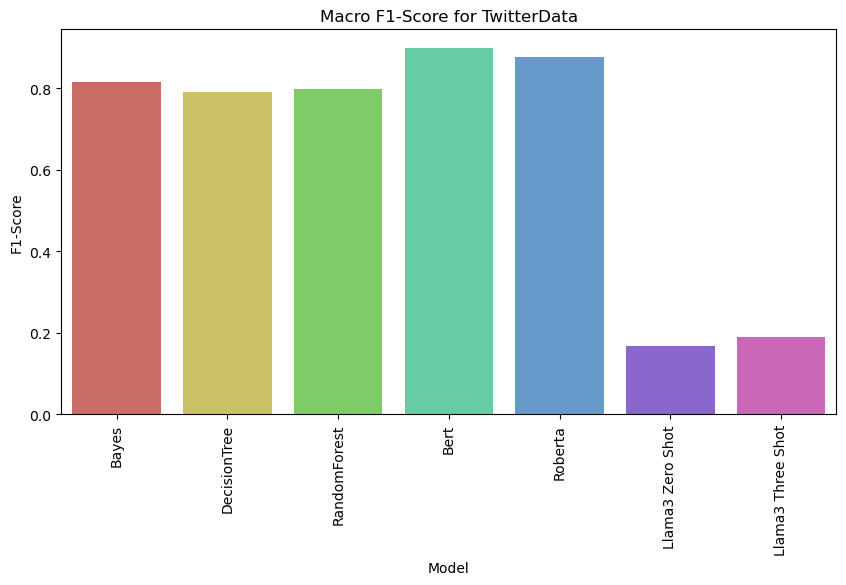

C:\Users\andre\AppData\Local\Temp\ipykernel_16248\191900150.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(print_dict.keys()), y=list(print_dict.values()), palette=sns.color_palette("hls", len(print_dict)))


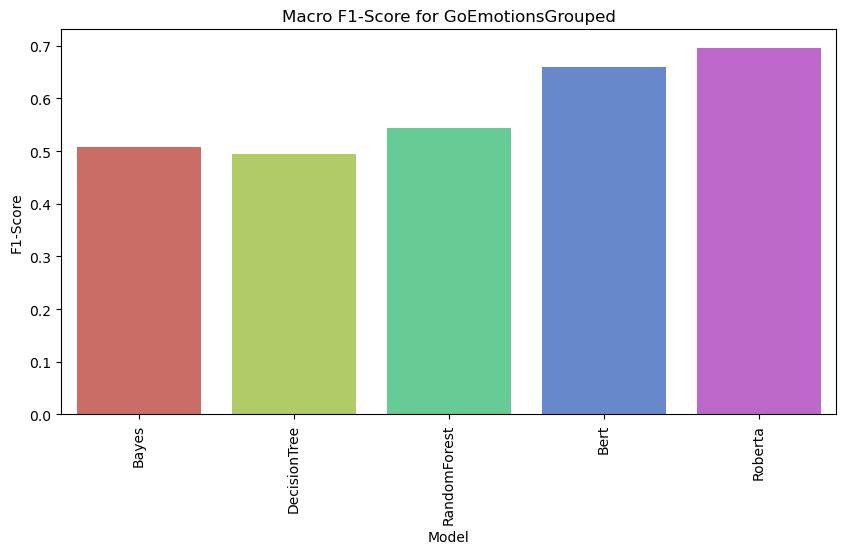

In [6]:
comparison_bar_plot(all_scores)

## Statistical testing

In [7]:
N_TESTS = 100
SAMPLE_SIZE = 200
# get best model for each dataset
best_models = {}
for dataset in DATASETS:
    best_model = max(all_scores[dataset].items(), key=lambda x: x[1]['macro avg']['f1-score'])[0]
    best_models[dataset] = best_model
    # get labels
    labels = get_dataset(dataset)[2]
    labels = labels[labels.columns[1:]]
    # get best model predictions
    best_predictions = predict(best_model, dataset)
    # compare best model with all other models according to bootstrap test
    for model in MODELS:
        if model != best_model:
            # get predictions
            predictions = predict(model, dataset)
            if predictions is None:
                continue
            print(f"Bootstrap test between {best_model} and {model} on {dataset}")
            bootstrap_test(best_predictions.values, predictions.values, labels, n_tests=N_TESTS, sample_size=SAMPLE_SIZE, metric_fun=f1_score, metric_name="Macro F1", metric_params={"average": "macro", "zero_division": 0})
            print("----------------------------------------------------------------------")

c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bootstrap test between Roberta and Bayes on GoEmotions
Initial Macro F1: 0.5313304575203343 0.2947884342317147
Best model: first, with delta: 0.23654202328861956
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Roberta and DecisionTree on GoEmotions
Initial Macro F1: 0.5313304575203343 0.337694987608631
Best model: first, with delta: 0.19363546991170327
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Roberta and RandomForest on GoEmotions
Initial Macro F1: 0.5313304575203343 0.3529656914545524
Best model: first, with delta: 0.17836476606578183
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Bootstrap test between Roberta and Bert on GoEmotions
Initial Macro F1: 0.5313304575203343 0.4704681434241724
Best model: first, with delta: 0.06086231409616183
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Roberta and Llama3 Zero Shot on GoEmotions
Initial Macro F1: 0.5313304575203343 0.07359380162183081
Best model: first, with delta: 0.45773665589850343
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Roberta and Llama3 Three Shot on GoEmotions
Initial Macro F1: 0.5313304575203343 0.0734787269326618
Best model: first, with delta: 0.4578517305876725
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Bootstrap test between Bert and Bayes on TwitterData
Initial Macro F1: 0.8993958452680566 0.8163722286322749
Best model: first, with delta: 0.08302361663578173
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Bert and DecisionTree on TwitterData
Initial Macro F1: 0.8993958452680566 0.790014462981154
Best model: first, with delta: 0.10938138228690264
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Bert and RandomForest on TwitterData
Initial Macro F1: 0.8993958452680566 0.7991018078494245
Best model: first, with delta: 0.10029403741863208
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bootstrap test between Bert and Roberta on TwitterData
Initial Macro F1: 0.8993958452680566 0.8757110298869679
Best model: first, with delta: 0.023684815381088686
Successes: 2/30
p-value: 0.06666666666666667
----------------------------------------------------------------------
Bootstrap test between Bert and Llama3 Zero Shot on TwitterData
Initial Macro F1: 0.8993958452680566 0.16643387964049805
Best model: first, with delta: 0.7329619656275586
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Bert and Llama3 Three Shot on TwitterData
Initial Macro F1: 0.8993958452680566 0.1892005697860076
Best model: first, with delta: 0.710195275482049
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bootstrap test between Roberta and Bayes on GoEmotionsGrouped
Initial Macro F1: 0.6962213193389594 0.5072372644892821
Best model: first, with delta: 0.18898405484967729
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Roberta and DecisionTree on GoEmotionsGrouped
Initial Macro F1: 0.6962213193389594 0.49364930629959264
Best model: first, with delta: 0.20257201303936673
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------
Bootstrap test between Roberta and RandomForest on GoEmotionsGrouped
Initial Macro F1: 0.6962213193389594 0.5434848878308441
Best model: first, with delta: 0.15273643150811522
Successes: 0/30
p-value: 0.0
----------------------------------------------------------------------


c:\Users\andre\anaconda3\envs\HLT\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Bootstrap test between Roberta and Bert on GoEmotionsGrouped
Initial Macro F1: 0.6962213193389594 0.6593787741282231
Best model: first, with delta: 0.036842545210736266
Successes: 2/30
p-value: 0.06666666666666667
----------------------------------------------------------------------
